In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import random as rd
import matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Filepath to shared drive
filepath = '/content/drive/MyDrive/AANDA/lab2/data_lab2/'

# Filepath to your own drive folder and files if it doesn't work
#filepath = ''

####General Functions

In [ ]:
#define the sin(2x) and square(2x) functions

def functions(x, noise_variance=None):

    y_sin = np.sin(2*x)
    y_square = np.sign(y_sin)
    y_square[y_square==0] = 1

    if noise_variance is not None:
        std = np.sqrt(noise_variance)
        y_sin += np.random.normal(scale=std, size=y_sin.shape)
        y_square += np.random.normal(scale=std, size=y_square.shape)

    return y_sin, y_square

In [ ]:
#error

def absolute_residual_error(pred, y):
    return np.mean(np.abs(pred-y))

#### RBFs Functions

In [ ]:
# RBF initialization

def place_rbfs(x, n_rbf, in_type = "random", sigma = None, CL=None):

    n_data, input_dim = np.shape(x) # Number of input patterns, input patterns dimension
    v = np.zeros((input_dim, n_rbf)) # RBF weights

    # Place RBFs to random datapoints
    if in_type == "random":
        indices = np.arange(n_data)
        #np.random.seed(1)
        np.random.shuffle(indices)

        for i in range(n_rbf):
            v[:, i] = x[indices[i],:]

    # Place the RBFs at equal distances in the plane
    elif in_type == "equal":
        low, high = x[0][0], x[-1][-1]
        v = np.linspace(low, high, n_rbf).reshape(1, n_rbf)

    if sigma is None: #so that the RBF don't overlap
        max_d = 0
        for i in range(n_rbf):
            for j in range(i+1, n_rbf):
                cur_d = np.absolute(v[:, i] - v[:, j])
                if (cur_d > max_d).any():
                    max_d = cur_d.max()
        sigma_rbf = float(max_d/np.sqrt(2*n_rbf))

    else:
        sigma_rbf = sigma

    if CL:  #CL is the amount of nodes which get affected in the competetive learning scheme
        #I'll use a predefined amount of epochs and lr, they should converge to roughly the same anyways
        epochs=200
        lr_init=0.3
        lr=lr_init
        X=x.copy()
        CLeffect=np.arange(CL,0,-1)/CL  #Gradually decreasing value determining how much "almost winners" get to learn

        for e in range(epochs):
            np.random.shuffle(X)
            for pattern in X:
                distances=euclidean(pattern, v.T)
                sortedind=np.argsort(distances)     #The index of the nodes sorted closest to furthest

                #Updates the closest nodes
                for i in range(CL):
                    v[:,sortedind[i]]=v[:,sortedind[i]] + lr*CLeffect[i]*(pattern - v[:,sortedind[i]])
            #Decay learning rate
            lr=lr-lr_init/epochs



    return v, sigma_rbf



# batch train

def batch_train(x, y, n_rbf, init_type = "random", sigma_tr = None, CL=None):

    v, sigma_rbf = place_rbfs(x, n_rbf, in_type = init_type, sigma = sigma_tr, CL=CL)
    n_data= np.shape(x)[0] # Number of input patterns

    hidden_activations = np.zeros((n_data, n_rbf))

    for j in range(n_rbf):
        for i in range(n_data):
            # Apply RBF transfer function (gaussian)
            dist = np.sqrt(np.dot(np.transpose((x.T[:, i] - v[:, j])), (x.T[:, i] - v[:, j])))
            # Compute hidden nodes activations
            hidden_activations[i, j] = np.exp((-(dist)**2)/(2*sigma_rbf**2))

    # Train the output weights
    w = np.dot(np.linalg.pinv(hidden_activations), y)

    return v, w, sigma_rbf



# online train

def online_train(x, y, n_rbf, init_type = "random", sigma_tr=None, eta=0.01, n_epochs=400):

    v, sigma_rbf = place_rbfs(x, n_rbf, in_type = init_type, sigma = sigma_tr)
    n_data, input_dim = np.shape(x) # Number of input patterns, input patterns dimension
    target_dim = y.shape[1]

    # Initialize w
    w = np.random.normal(0, 0.1, (n_rbf, target_dim))

    hidden_activations = np.zeros((n_rbf, input_dim))

    for epoch in range(n_epochs):
        inputs = np.stack((x, y), axis = -1).reshape(n_data, input_dim+target_dim) #merge the x and y together to shuffle
        np.random.shuffle(inputs) # shuffle

        x, y = np.split(inputs, [1], axis = 1)

        # Loop over the input patterns
        for i in range(x.shape[0]):

            # Compute hidden nodes activations for input pattern i
            for j in range(n_rbf):

                # Apply RBF transfer function (gaussian)
                hidden_activations[j, :] = np.exp((-(x[i,:] - v[:,j])**2)/(2*sigma_rbf**2))

            # Update the weights
            w += eta * (y[i,:] - np.dot(np.transpose(hidden_activations), w)) * hidden_activations

    return v, w, sigma_rbf

# predict

def predict(x, y, v, w, n_rbf, sigma_te):

    n_data = np.shape(x)[0] # Number of input patterns

    # Compute hidden nodes activations
    hidden_activations = np.zeros((n_data, n_rbf))

    for j in range(n_rbf):
        for i in range(n_data):
            #Apply RBF transfer function (gaussian)
            dist = np.sqrt(np.dot(np.transpose((x.T[:, i] - v[:, j])), (x.T[:, i] - v[:, j])))
            # Compute hidden nodes activations
            hidden_activations[i, j] = np.exp((-(dist)**2)/(2*sigma_te**2))

    # Return outputs
    pred = np.dot(hidden_activations, w)

    return pred

#### MLP Functions

In [ ]:
def standard_activation_function(x, derivative=False):
  if not derivative:
    return 2/(1 + math.e**(-x))-1
  else: #This is an inefficient solution since we could save the value from the forward pass and reuse it. But since we only use one layer it does not make a large difference
    temp=2/(1 + math.e**(-x))-1
    return (1+temp)*(1-temp)*0.5

In [ ]:
class NeuralNetwork:

    def __init__(self, X, y, n_hidden_neurons, eta, alpha = 0, activation_function = standard_activation_function):

        self.X_bias = np.r_['0,2', X, np.ones(X.shape[1])]  #Input with added bias (features+1, samples)
        self.y = y  #Targets

        self.n_samples = X.shape[1]
        self.n_features = X.shape[0] + 1
        self.n_output_features = 1 if y.ndim==1 else y.shape[0]
        self.n_hidden_neurons = n_hidden_neurons

        self.epochs_trained = 0
        self.eta = eta
        self.alpha = alpha
        self.activation_function = activation_function

        self.create_biases_and_weights()


    def create_biases_and_weights(self):

        # create weights from input to hidden layer
        self.hidden_weights = np.random.randn(self.n_hidden_neurons, self.n_features)

        #create weights from hidden to output
        self.output_weights = np.random.randn(self.n_output_features, self.n_hidden_neurons+1)


    def feed_forward(self):
        # feed-forward for training

        # from input to hidden layer
        self.h_in = self.hidden_weights @ self.X_bias
        self.h_out = self.activation_function(self.h_in)
        self.h_out=np.r_['0,2', self.h_out, np.ones(self.h_out.shape[1])]

        #from hidden to output layer
        self.o_in = self.output_weights @ self.h_out
        self.o_out = self.activation_function(self.o_in)


    def feed_forward_out(self, X):
        # feed-forward for output

        X = np.r_['0,2', X, np.ones(X.shape[1])]

        # from input to hidden layer
        h_in = self.hidden_weights @ X
        h_out = self.activation_function(h_in)
        h_out=np.r_['0,2', h_out, np.ones(h_out.shape[1])]

        #from hidden to output layer
        o_in = self.output_weights @ h_out
        o_out = self.activation_function(o_in)

        return o_out

    def backpropagation(self):

        #calculate the output error
        self.error_output = self.o_out - self.y

        #iterate the error back (output)
        self.delta_o = self.error_output * self.activation_function(self.o_in, derivative=True)
        #self.delta_o = self.error_output * self.activation_function(self.o_out, derivative=True)
        self.grad_o = self.delta_o @ self.h_out.T

        #iterate the error back (hidden)
        self.delta_h = (self.output_weights.T @ self.delta_o)[:self.n_hidden_neurons] * self.activation_function(self.h_in, derivative=True)
        #self.delta_h = (self.output_weights.T @ self.delta_o) * self.activation_function(self.h_out, derivative=True)
        #self.delta_h = self.delta_h[:self.n_hidden_neurons, :]
        self.grad_h = self.delta_h @ self.X_bias.T
        #delta_h = delta_h(0:self.n_hidden_neurons, :)

        # weight update with momentum
        # if alpha = 0: self.output_weights -= self.eta * self.grad_o
        self.output_weights += self.eta * ((self.alpha * self.output_weights) - ((1 - self.alpha) * self.grad_o))
        self.hidden_weights += self.eta * ((self.alpha * self.hidden_weights) - (( 1- self.alpha) * self.grad_h))

    def predict(self, X):
        values = self.feed_forward_out(X)
        return values

    def train(self, epochs):
        for i in range(epochs):
            self.feed_forward()
            self.backpropagation()
            self.epochs_trained+=1

####Print functions

In [ ]:
#Function which takes in an array of point (2,n) and corresponding labels (n) and then prints a scatter plot for the data
def printBinaryData(data, labels, title, y_lim_sub = -0.75, y_lim_sup = 0.95, xlab = "x1", ylab = "x2"):
    plt.figure(figsize=(7,7))
    scatter = plt.scatter(data[0,:], data[1,:], c=labels)
    plt.legend(*scatter.legend_elements())
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.ylim(y_lim_sub, y_lim_sup)

#Function which draws a crude approximation of the decision boundary of a binary MLP with one output node
def printDecisionBoundary(NN, resolution=100, boundaryWidth=0.05, color="r"):
  N=resolution**2
  x1min, x1max=min(NN.X_bias[0]), max(NN.X_bias[0])
  x1size=x1max-x1min
  x2min, x2max=min(NN.X_bias[0]), max(NN.X_bias[0])
  x2size=x2max-x1min

  #Create test points
  testPoints=np.zeros((2,N))
  for i in range(resolution):
    testPoints[0,(i*resolution):((i+1)*resolution)]=np.linspace(x1min,x1max,resolution)
    testPoints[1,(i*resolution):((i+1)*resolution)]=x2min+i*x2size/resolution

  #Find points which almost evaluate to zero
  output=NN.feed_forward_out(testPoints)
  pointsAndOutput=np.concatenate((testPoints,output),axis=0)
  boundaryPoints=pointsAndOutput[:2,abs(pointsAndOutput[2]) < boundaryWidth]

  plt.scatter(boundaryPoints[0],boundaryPoints[1], c=color)

#Plotts from a coordinate mesh of x, y with corresponding result z (All three as matrixes)
def plot3D(x,y,z, title="test", zlim=(-0.7, 0.7), c="b"):
  ax = plt.figure(figsize=(10,10)).add_subplot(111, projection='3d')
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_zlim(zlim)
  ax.set_title(title)

  #ax.plot_surface(x,y,z, color=c)
  ax.plot_wireframe(x,y,z, color=c)

#Assumes points is a flattened square mesh
def print3DFromNetwork(points, nn, titel="test", zlim=(-0.7, 0.7), c="b"):
  N=points.shape[1]
  n=round(np.sqrt(N))
  assert(n*n==N)
  X=points[0,:].reshape((n,n))
  Y=points[1,:].reshape((n,n))
  Z=nn.predict(points).reshape((n,n))

  plot3D(X,Y,Z,titel,zlim, c)

####Functions for splitting data into subsets

In [ ]:
#Function for splitting dataset (Assumes shuffled data set)
# split_type="percentage": splits the first p % of the data
# split_type="splitA": removes p % of class A  (assumes class A and B binary, one output node with labels 1, -1)
# split_type="splitB": removes p % of class B  (assumes class A and B binary, one output node with labels 1, -1)
# split_type="splitEven": removes p % from both classes (assumes class A and B binary, one output node with labels 1, -1)
# split_type="special": cuts out 20% of class a where x1 less than zero and 80% where x1 greater than zero

def splitData(data, targets, p=50, split_type="percentage"):
    p=p/100
    targetDim = targets.ndim
    N = len(targets) if targetDim==1 else targets.shape[1]
    #variables for if there are two classes
    nA, nB = 0 ,0
    dataA, dataB = 0, 0

    if split_type=="splitEven" or split_type=="splitA" or split_type=="splitB" or split_type=="special": #Allows the data to be unevenly split and/or already shuffled before being sent into the function.
      targetsWithIndex=np.concatenate((targets.reshape((1,N)), np.arange(N).reshape((1,N))), axis=0)
      indexesA=targetsWithIndex[1,targetsWithIndex[0]==1].astype(int)
      indexesB=targetsWithIndex[1,targetsWithIndex[0]==-1].astype(int)
      nA=len(indexesA)
      nB=len(indexesB)
      dataA=data[:,indexesA]
      dataB=data[:,indexesB]

    splitData, splitTargets, residualData, residualTargets = 0,0,0,0

    if split_type=="percentage":
      splitData=data[:,:round(p*N)]
      splitTargets=targets[:round(p*N)] if targets.ndim==1 else targets[:,:round(p*N)]  #Allows for output of more than 1 node
      residualData=data[:,round(p*N):]
      residualTargets=targets[round(p*N):] if targets.ndim==1 else targets[:,round(p*N):]

    elif split_type=="splitEven":
      splitDataA=dataA[:,:round((1-p)*nA)]
      splitDataB=dataB[:,:round((1-p)*nB)]
      splitData=np.concatenate((splitDataA,splitDataB), axis=1)

      splitTargetsA=np.ones(round((1-p)*nA))
      splitTargetsB=(-np.ones(round((1-p)*nB)))
      splitTargets=np.concatenate((splitTargetsA, splitTargetsB))

      splitData, splitTargets = shuffle_data(splitData, splitTargets)

      residualDataA=dataA[:,round((1-p)*nA):]
      residualDataB=dataB[:,round((1-p)*nB):]
      residualData=np.concatenate((residualDataA,residualDataB), axis=1)

      residualTargetsA=np.ones(round(p*nA))
      residualTargetsB=(-np.ones(round(p*nA)))
      residualTargets=np.concatenate((residualTargetsA, residualTargetsB))

      residualData, residualTargets = shuffle_data(residualData, residualTargets)

    elif split_type=="splitA" or split_type=="splitB":
      if split_type=="splitA":
        splitDataA=dataA[:,:round((1-p)*nA)]
        splitDataB=dataB

        residualDataA=dataA[:,round((1-p)*nA):]
        residualDataB=np.ndarray((2,0))

        splitTargetsA=np.ones(round((1-p)*nA))
        splitTargetsB=(-np.ones(nB))

        residualTargetsA=np.ones(round(p*nA))
        residualTargetsB=(-np.ones(0))
      else:
        splitDataA=dataA
        splitDataB=dataB[:,:round((1-p)*nB)]

        residualDataA=np.ndarray((2,0))
        residualDataB=dataB[:,round((1-p)*nB):]

        splitTargetsA=np.ones(nA)
        splitTargetsB=(-np.ones(round((1-p)*nB)))

        residualTargetsA=np.ones(0)
        residualTargetsB=(-np.ones(round(p*nB)))

      splitData=np.concatenate((splitDataA,splitDataB), axis=1)
      splitTargets=np.concatenate((splitTargetsA, splitTargetsB))
      splitData, splitTargets = shuffle_data(splitData, splitTargets)

      residualData=np.concatenate((residualDataA,residualDataB), axis=1)
      residualTargets=np.concatenate((residualTargetsA, residualTargetsB))
      residualData, residualTargets = shuffle_data(residualData, residualTargets)

    elif split_type=="special":
      dataAltZero = dataA[:,dataA[0] < 0]
      dataAgtZero = dataA[:,dataA[0] >= 0]
      nAltZero=dataAltZero.shape[1]
      nAgtZero=dataAgtZero.shape[1]

      splitDataAltZero=dataAltZero[:,:round(nAltZero*0.8)]
      splitDataAgtZero=dataAgtZero[:,:round(nAgtZero*0.2)]
      splitDataA=np.concatenate((splitDataAltZero,splitDataAgtZero), axis=1)

      splitData=np.concatenate((splitDataA,dataB),axis=1)

      splitTargetsA=np.ones(splitDataA.shape[1])
      splitTargetsB=(-np.ones(nB))

      splitTargets=np.concatenate((splitTargetsA, splitTargetsB))

      splitData, splitTargets = shuffle_data(splitData, splitTargets)

      residualDataAltZero=dataAltZero[:,round(nAltZero*0.8):]
      residualDataAgtZero=dataAgtZero[:,round(nAgtZero*0.2):]
      residualDataA=np.concatenate((splitDataAltZero,splitDataAgtZero), axis=1)

      residualData=residualDataA

      residualTargets=np.ones(residualData.shape[1])

      residualData, residualTargets = shuffle_data(residualData, residualTargets)


    else:
      print("Error!!!!!!!!!!!!!", split_type, "is not an acceptable split type")

    return splitData, splitTargets, residualData, residualTargets

# RBFs

## 3.1

Generate Clean Data (not Noisy)

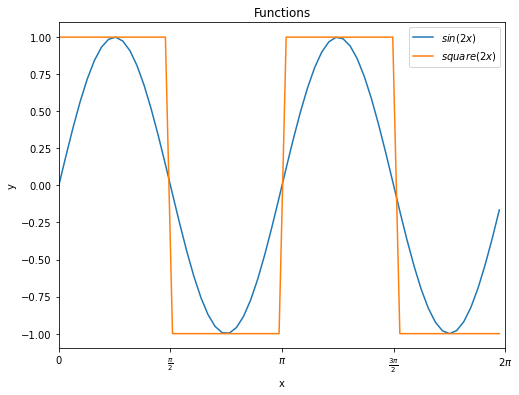

In [ ]:
# training and test data
x = np.arange(0, 2*np.pi, 0.1)[:, np.newaxis]
x_test = np.arange(0.05, 2*np.pi, 0.1)[:, np.newaxis]

y_sin, y_square = functions(x, noise_variance=None)
y_sin_test, y_square_test = functions(x_test, noise_variance=None)


# Plot functions
plt.figure(figsize=(8,6))
plt.plot(x, y_sin, label="$sin(2x)$")
plt.plot(x, y_square, label="$square(2x)$")
plt.title("Functions")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
plt.legend(loc = "upper right")

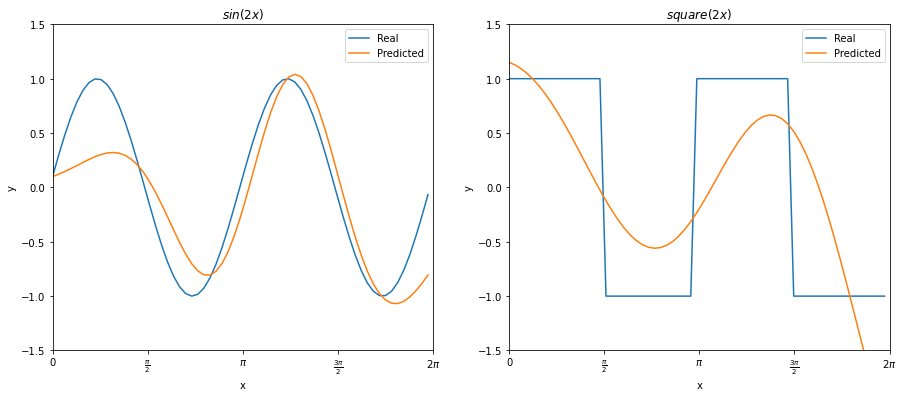

In [ ]:
# Plot predictions
np.random.seed(1)

v, w, sig = batch_train(x, y_sin, 4)
pred_sin = predict(x_test, y_sin_test, v, w, 4, sig)

v, w, sig = batch_train(x, y_square, 4)
pred_square = predict(x_test, y_square_test, v, w, 4, sig)

plt.figure(figsize=(15,6))

plt.subplot(121)
plt.plot(x, y_sin_test, label="Real")
plt.plot(x, pred_sin, label="Predicted")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
plt.ylim([-1.5,1.5])
plt.title("$sin(2x)$")
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
plt.legend(loc = "upper right")

plt.subplot(122)
plt.plot(x, y_square_test, label="Real")
plt.plot(x, pred_square, label="Predicted")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0, 2*np.pi])
plt.ylim([-1.5, 1.5])
plt.title("$square(2x)$")
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
plt.legend(loc = "upper right")

### Sin(2x)

#### Random Initialization

In [ ]:
start_time = time.time()

n_unites = np.arange(4,16,1)
random_err_sin = np.zeros((50, len(n_unites)))

np.random.seed(1)

for l in range(0,50):
    for j, n in enumerate(n_unites):

        v, w, sig = batch_train(x, y_sin, n)
        pred_sin = predict(x_test, y_sin_test, v, w, n, sig)
        random_err_sin[l,j] = absolute_residual_error(pred_sin, y_sin_test)

mu_sin = []
std_sin = []

for i in range(len(n_unites)):
    mu_sin.append(np.mean(random_err_sin[:,i]))
    std_sin.append(np.std(random_err_sin[:,i]))

print(mu_sin, "\n", std_sin)

print("--- %s seconds ---" % (time.time() - start_time))

[0.4307765113884849, 0.2802919277063737, 0.11062093723198738, 0.0615309306555885, 0.03273790823249658, 0.014990104852078565, 0.006592371871990572, 0.006156440787197978, 0.0026977951060669315, 0.0030287827834757112, 0.0011038021937542282, 0.00030439237031193103] 
 [0.07278260132000161, 0.10542750552604292, 0.06565184717857989, 0.03492093110641169, 0.04558676563781347, 0.01610424475994434, 0.008726861598642784, 0.011979462857738175, 0.006373536791623387, 0.006680191179220534, 0.004465148328841407, 0.0008580922525348326]
--- 8.343503475189209 seconds ---


#### Equal-spaced Initialization

In [ ]:
start_time = time.time()

n_unites = np.arange(4,16,1)
equal_err_sin = np.zeros((len(n_unites)))

for j, n in enumerate(n_unites):

    v, w, sig = batch_train(x, y_sin, n, "equal")
    pred_sin = predict(x_test, y_sin_test, v, w, n, sig)
    equal_err_sin[j] = absolute_residual_error(pred_sin, y_sin_test)

print(equal_err_sin)

print("--- %s seconds ---" % (time.time() - start_time))

[4.72434862e-01 4.62403822e-01 4.60171352e-02 3.39430961e-02
 4.98127951e-03 4.70100862e-03 7.44697880e-04 7.98709211e-04
 1.41891172e-04 1.63444958e-04 3.02362958e-05 3.60814586e-05]
--- 0.31436777114868164 seconds ---


#### Plots

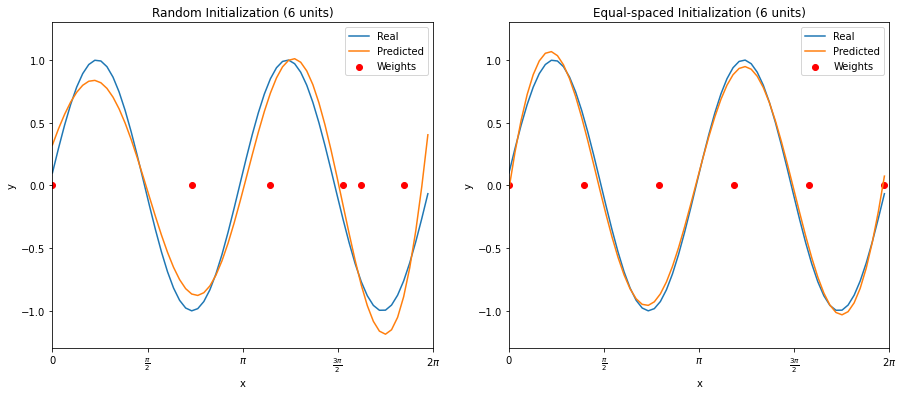

In [ ]:
np.random.seed(2)

v_rand, w, sig = batch_train(x, y_sin, 6)
pred_sin = predict(x_test, y_sin_test, v_rand, w, 6, sig)

v_eq, w, sig = batch_train(x, y_sin, 6, "equal")
pred_sin_eq = predict(x_test, y_sin_test, v_eq, w, 6, sig)

plt.figure(figsize=(15,6))

plt.subplot(121)
plt.plot(x, y_sin_test, label="Real")
plt.plot(x, pred_sin, label="Predicted")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
plt.ylim([-1.3,1.3])
plt.title("Random Initialization (6 units)")
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)

visualizeRBFs(v_rand, color="r", lab = "Weights")
plt.legend(loc = "upper right")

plt.subplot(122)
plt.plot(x, y_sin_test, label="Real")
plt.plot(x, pred_sin_eq, label="Predicted")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
plt.ylim([-1.3,1.3])
plt.title("Equal-spaced Initialization (6 units)")
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)

visualizeRBFs(v_eq, color="r", lab = "Weights")
plt.legend(loc = "upper right")

### Square(2x)

#### Random Initialization and No Tresholding

In [ ]:
start_time = time.time()

n_unites = np.arange(10,61,5)
random_err_square = np.zeros((50, len(n_unites)))

np.random.seed(1)

for l in range(0,50):
    for j, n in enumerate(n_unites):

        v, w, sig = batch_train(x, y_square, n)
        pred_square = predict(x_test, y_square_test, v, w, n, sig)
        random_err_square[l,j] = absolute_residual_error(pred_square, y_square_test)

mu_square = []
std_square = []

for i in range(len(n_unites)):
    mu_square.append(np.mean(random_err_square[:,i]))
    std_square.append(np.std(random_err_square[:,i]))

print(mu_square, std_square)

print("--- %s seconds ---" % (time.time() - start_time))

[0.27510541281071055, 0.21636667814529484, 0.18076899006386937, 0.18854584950900702, 0.1627835737268738, 0.15884591693991537, 0.15223943299717374, 0.2026957904817447, 0.28958640157067334, 0.16277847040090787, 0.18210160649012003] [0.0060603677472668115, 0.013553610293410977, 0.003535982356017533, 0.01837949747369271, 0.013684990975734836, 0.013173493650595426, 0.010255125603677508, 0.04584620210702618, 0.03301085130613788, 0.02334221308604597, 0.01592667354355393]
--- 40.32272410392761 seconds ---


#### Equal-spaced Initialization and No Tresholding

In [ ]:
start_time = time.time()

n_unites = np.arange(10,61,5)
equal_err_square = np.zeros((len(n_unites)))

for j, n in enumerate(n_unites):

    v, w, sig = batch_train(x, y_square, n, "equal")
    pred_square = predict(x_test, y_square_test, v, w, n, sig)
    equal_err_square[j] = absolute_residual_error(pred_square, y_square_test)

print(equal_err_square)

print("--- %s seconds ---" % (time.time() - start_time))

[0.27503455 0.25146988 0.18082941 0.1873302  0.17129522 0.1570469
 0.14314325 0.21132269 0.30998979 0.14658694 0.1597944 ]
--- 0.7142326831817627 seconds ---


#### Random Initialization and Tresholding

In [ ]:
start_time = time.time()

n_unites = np.arange(4,16,1)
random_err_square_t = np.zeros((50, len(n_unites)))

for l in range(0,50):
    for j, n in enumerate(n_unites):

        v, w, sig = batch_train(x, y_square, n)
        pred_square = predict(x_test, y_square_test, v, w, n, sig)
        pred_square_t = np.array([-1.0 if i < 0 else 1.0 for i in pred_square]).reshape(63,1)

        random_err_square_t[l,j] = absolute_residual_error(pred_square_t, y_square_test)

mu_square_t = []
std_square_t = []

for i in range(len(n_unites)):
    mu_square_t.append(np.mean(random_err_square_t[:,i]))
    std_square_t.append(np.std(random_err_square_t[:,i]))

print(mu_square_t, "\n", std_square_t)

print("--- %s seconds ---" % (time.time() - start_time))

[0.30476190476190473, 0.2038095238095238, 0.07936507936507935, 0.05333333333333333, 0.04, 0.017777777777777778, 0.021587301587301582, 0.012698412698412698, 0.01714285714285714, 0.0438095238095238, 0.07873015873015873, 0.07936507936507936] 
 [0.1648349839459958, 0.1591220558948684, 0.09571310115353228, 0.07657048092282583, 0.10429139169392788, 0.01575831574094077, 0.014808766717067429, 0.01679842102263232, 0.023934065809486683, 0.031033268342476026, 0.01586031237688482, 0.015873015873015872]
--- 9.265259027481079 seconds ---


#### Equal-spaced Initialization and Tresholding

In [ ]:
start_time = time.time()

n_unites = np.arange(4,16,1)
equal_err_square_t = np.zeros((len(n_unites)))

for j, n in enumerate(n_unites):

    v, w, sig = batch_train(x, y_square, n, "equal")
    pred_square = predict(x_test, y_square_test, v, w, n, sig)
    pred_square_t = np.array([-1.0 if i < 0 else 1.0 for i in pred_square]).reshape(63,1)

    equal_err_square_t[j] = absolute_residual_error(pred_square_t, y_square_test)

print(equal_err_square_t)

print("--- %s seconds ---" % (time.time() - start_time))

[0.22222222 0.25396825 0.06349206 0.0952381  0.         0.
 0.03174603 0.         0.         0.03174603 0.06349206 0.0952381 ]
--- 0.15225696563720703 seconds ---


#### Comparison Plots


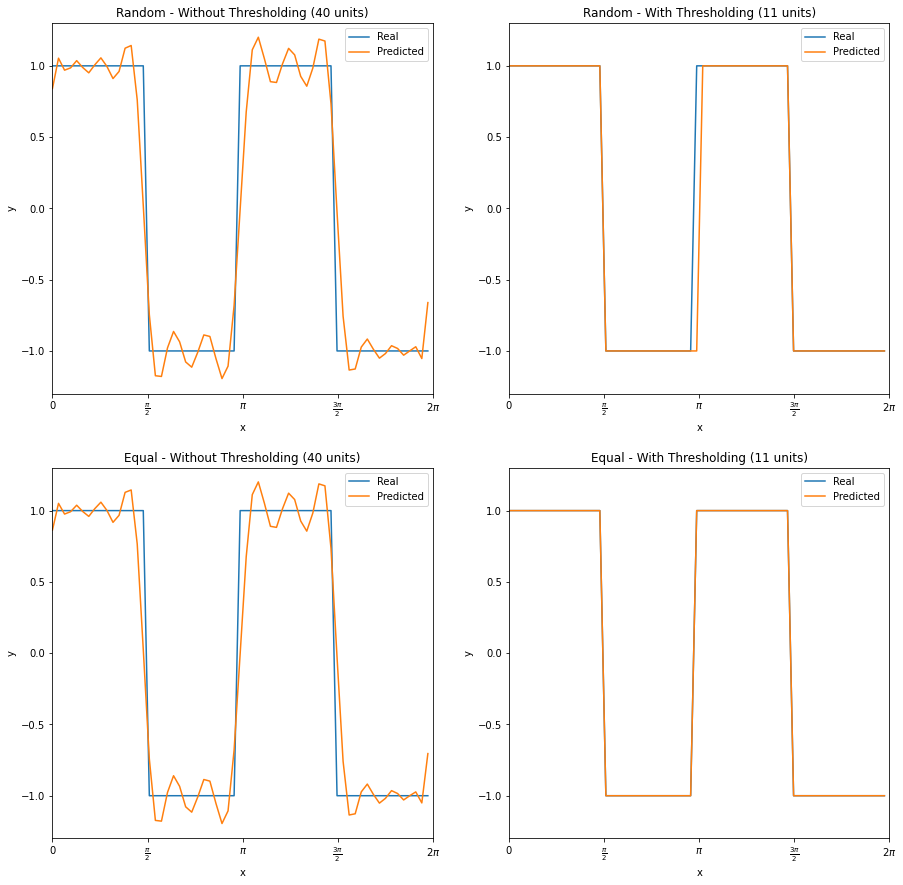

In [ ]:
np.random.seed(18)

v_square, w_square, sig_square = batch_train(x, y_square,11)
pred_square = predict(x_test, y_square_test, v_square, w_square,11, sig_square)
pred_square_t = np.array([-1.0 if i < 0 else 1.0 for i in pred_square]).reshape(63,1)

v_square, w_square, sig_square = batch_train(x, y_square, 40)
pred_square_not = predict(x_test, y_square_test, v_square, w_square, 40, sig_square)

v_square, w_square, sig_square = batch_train(x, y_square, 11, "equal")
pred_square = predict(x_test, y_square_test, v_square, w_square, 11, sig_square)
pred_square_teq = np.array([-1.0 if i < 0 else 1.0 for i in pred_square]).reshape(63,1)
#print(pred_square_teq == y_square_test)

v_square, w_square, sig_square = batch_train(x, y_square, 40, "equal")
pred_square_eq = predict(x_test, y_square_test, v_square, w_square, 40, sig_square)

plt.figure(figsize=(15,15))

plt.subplot(221)
plt.plot(x, y_square_test, label="Real")
plt.plot(x, pred_square_not, label="Predicted")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
plt.ylim([-1.3,1.3])
plt.title("Random - Without Thresholding (40 units)")
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
plt.legend(loc = "upper right")

plt.subplot(222)
plt.plot(x, y_square_test, label="Real")
plt.plot(x, pred_square_t, label="Predicted")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
plt.ylim([-1.3,1.3])
plt.title("Random - With Thresholding (11 units)")
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
plt.legend(loc = "upper right")

plt.subplot(223)
plt.plot(x, y_square_test, label="Real")
plt.plot(x, pred_square_eq, label="Predicted")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
plt.ylim([-1.3,1.3])
plt.title("Equal - Without Thresholding (40 units)")
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
plt.legend(loc = "upper right")

plt.subplot(224)
plt.plot(x, y_square_test, label="Real")
plt.plot(x, pred_square_teq, label="Predicted")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
plt.ylim([-1.3,1.3])
plt.title("Equal - With Thresholding (11 units)")
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
plt.legend(loc = "upper right")

In [ ]:
print(mu_sin, "\n", equal_err_sin, "\n", mu_square, "\n", equal_err_square,  "\n", mu_square_t,  "\n", equal_err_square_t)

[0.4307765113884849, 0.2802919277063737, 0.11062093723198738, 0.0615309306555885, 0.03273790823249658, 0.014990104852078565, 0.006592371871990572, 0.006156440787197978, 0.0026977951060669315, 0.0030287827834757112, 0.0011038021937542282, 0.00030439237031193103] 
 [4.72434862e-01 4.62403822e-01 4.60171352e-02 3.39430961e-02
 4.98127951e-03 4.70100862e-03 7.44697880e-04 7.98709211e-04
 1.41891172e-04 1.63444958e-04 3.02362958e-05 3.60814586e-05] 
 [0.27510541281071055, 0.21636667814529484, 0.18076899006386937, 0.18854584950900702, 0.1627835737268738, 0.15884591693991537, 0.15223943299717374, 0.2026957904817447, 0.28958640157067334, 0.16277847040090787, 0.18210160649012003] 
 [0.27503455 0.25146988 0.18082941 0.1873302  0.17129522 0.1570469
 0.14314325 0.21132269 0.30998979 0.14658694 0.1597944 ] 
 [0.30476190476190473, 0.2038095238095238, 0.07936507936507935, 0.05333333333333333, 0.04, 0.017777777777777778, 0.021587301587301582, 0.012698412698412698, 0.01714285714285714, 0.04380952380952

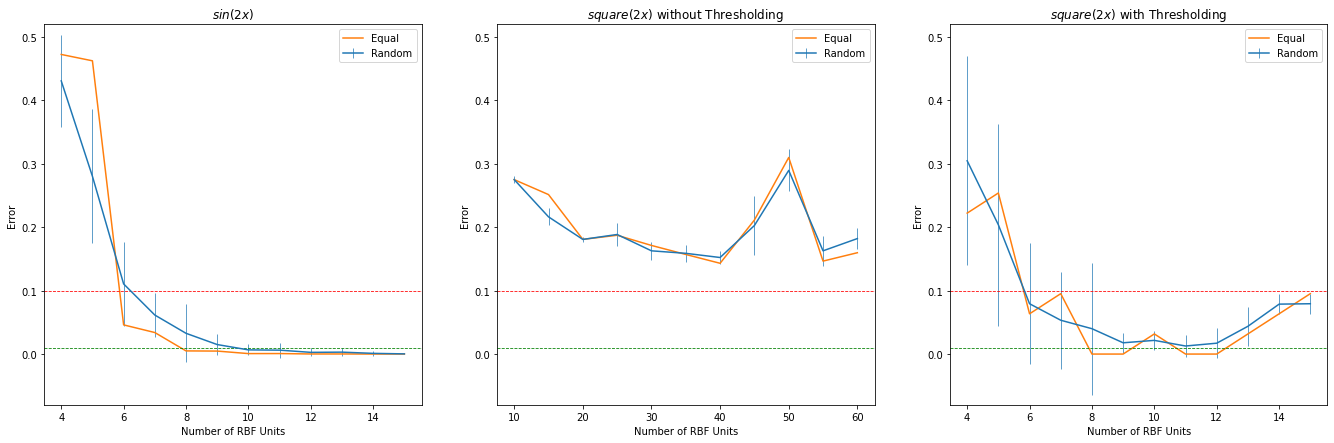

In [ ]:
# Plot errors random init

plt.figure(figsize=(23,7))
#plt.suptitle("Errors vs number of RBF units")

plt.subplot(131)
plt.errorbar(np.arange(4,16,1), mu_sin, yerr=std_sin, elinewidth = 0.7, label = "Random")
plt.plot(np.arange(4,16,1), equal_err_sin, label = "Equal")
plt.axhline(y = 0.1, color = "red", linewidth = 0.8, ls = "--")
plt.axhline(y = 0.01,color = "green", linewidth = 0.8, ls = "--")
plt.xlabel("Number of RBF Units")
plt.ylabel("Error")
plt.ylim([-0.08, 0.52])
plt.title("$sin(2x)$")
plt.legend()

plt.subplot(132)
plt.errorbar(np.arange(10,61,5), mu_square, yerr=std_square, elinewidth = 0.7, label = "Random")
plt.plot(np.arange(10,61,5), equal_err_square, label = "Equal")
plt.axhline(y = 0.1, color = "red", linewidth = 0.8, ls = "--")
plt.axhline(y = 0.01,color = "green", linewidth = 0.8, ls = "--")
plt.xlabel("Number of RBF Units")
plt.ylabel("Error")
plt.ylim([-0.08, 0.52])
plt.title("$square(2x)$ without Thresholding")
plt.legend()

plt.subplot(133)
plt.errorbar(np.arange(4,16,1), mu_square_t, yerr=std_square_t, elinewidth = 0.7, label ="Random")
plt.plot(np.arange(4,16,1), equal_err_square_t, label ="Equal")
plt.axhline(y = 0.1, color = "red", linewidth = 0.8, ls = "--")
plt.axhline(y = 0.01,color = "green", linewidth = 0.8, ls = "--")
plt.xlabel("Number of RBF Units")
plt.ylabel("Error")
plt.ylim([-0.08, 0.52])
plt.title("$square(2x)$ with Thresholding")
plt.legend()

## 3.2

Generate Noisy Training and Test data

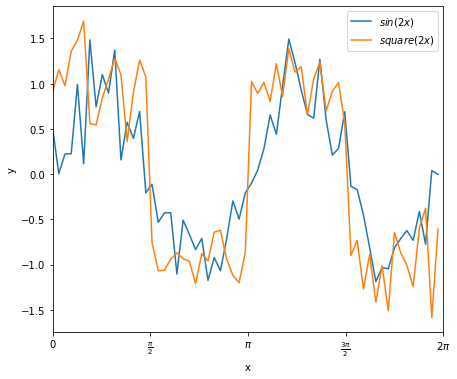

In [ ]:
np.random.seed(1)
y_sin_n, y_square_n = functions(x, noise_variance=0.1)
y_sin_test_n, y_square_test_n = functions(x_test, noise_variance=0.1)


# Plot functions
plt.figure(figsize=(7,6))
plt.plot(x, y_sin_n, label="$sin(2x)$")
plt.plot(x, y_square_n, label="$square(2x)$")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
plt.legend(loc = "upper right")

### Sin(2x) noisy

##### Batch and equal-spaced

In [ ]:
start_time = time.time()

n_unites = np.arange(4,16,1)
variances = np.linspace(0.5, 2, 5)
batch_err_sin = np.zeros((len(variances), len(n_unites)))

for j, n in enumerate(n_unites):
    for i, var in enumerate(variances):

        v, w, sig = batch_train(x, y_sin_n, n, "equal", var)
        pred_sin_n = predict(x_test, y_sin_test_n, v, w, n, sig)
        batch_err_sin[i,j] = absolute_residual_error(pred_sin_n, y_sin_test_n)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.8222064971923828 seconds ---


##### Online and equal-spaced

In [ ]:
start_time = time.time()

n_unites = np.arange(4,16,1)
variances = np.linspace(0.5, 2, 5)
online_err_sin = np.zeros((len(variances), len(n_unites)))

np.random.seed(15)

for j, n in enumerate(n_unites):
    for i, var in enumerate(variances):

        v, w, sig = online_train(x, y_sin_n, n, "equal", var, eta = 0.05)
        pred_sin = predict(x_test, y_sin_test_n, v, w, n, sig)
        online_err_sin[i,j] = absolute_residual_error(pred_sin, y_sin_test_n)

print("--- %s seconds ---" % (time.time() - start_time))

--- 127.16245794296265 seconds ---


#### Comparison plots

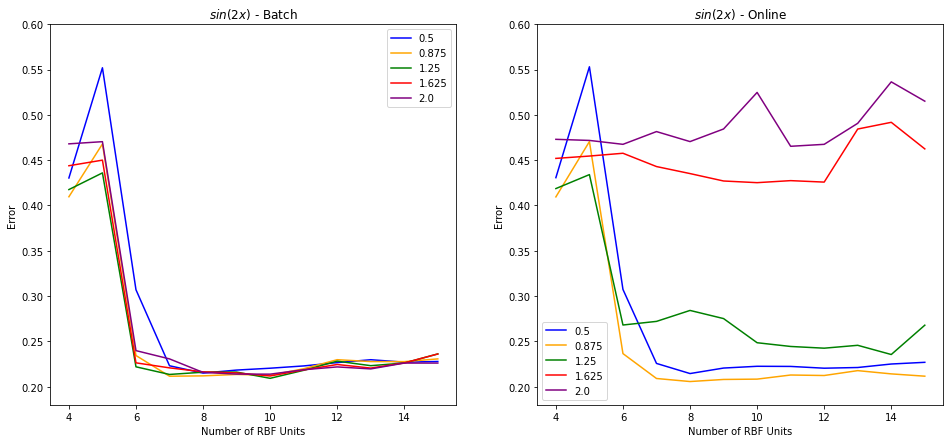

In [ ]:
color = ["blue", "orange", "green", "red", "purple"]

plt.figure(figsize=(16,7))

plt.subplot(121)
for i in range(0,len(variances)):
    plt.plot(np.arange(4,16,1), batch_err_sin[i, :], c = color[i], label = variances[i])
plt.xlabel("Number of RBF Units")
plt.ylabel("Error")
plt.ylim([0.18, 0.6])
plt.title("$sin(2x)$ - Batch")
plt.legend()

plt.subplot(122)
for i in range(0, len(variances)):
    plt.plot(np.arange(4,16,1), online_err_sin[i, :], c = color[i], label = variances[i])
plt.xlabel("Number of RBF Units")
plt.ylabel("Error")
plt.ylim([0.18, 0.6])
plt.title("$sin(2x)$ - Online")
plt.legend()

for batch: lower with sigma = 1.25 for 10 RBFs (0.209)

for online: lower with sigma = 0.875 for 8 RBFs (0.207)

However batch is faster (0.7seconds against 135 seconds) and more robust.

### Square(2x) Noisy

#### Batch and equal-spaced

In [ ]:
start_time = time.time()

n_unites = np.arange(4,16,1)
variances = np.linspace(0.5, 2, 5)
batch_err_square = np.zeros((len(variances), len(n_unites)))

for j, n in enumerate(n_unites):
    for i, var in enumerate(variances):

        v, w, sig = batch_train(x, y_square_n, n, "equal", var)
        pred_square = predict(x_test, y_square_test_n, v, w, n, sig)
        batch_err_square[i,j] = absolute_residual_error(pred_square, y_square_test_n)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.7551321983337402 seconds ---


#### Online and equal-spaced

In [ ]:
start_time = time.time()

n_unites = np.arange(4,16,1)
variances = np.linspace(0.5, 2, 5)
online_err_square = np.zeros((len(variances), len(n_unites)))

np.random.seed(15)

for j, n in enumerate(n_unites):
    for i, var in enumerate(variances):

        v, w, sig = online_train(x, y_square_n, n, "equal", var, eta = 0.05)
        pred_square = predict(x_test, y_square_test_n, v, w, n, sig)
        online_err_square[i,j] = absolute_residual_error(pred_square, y_square_test_n)

print("--- %s seconds ---" % (time.time() - start_time))

--- 134.43334102630615 seconds ---


#### Comparison plots

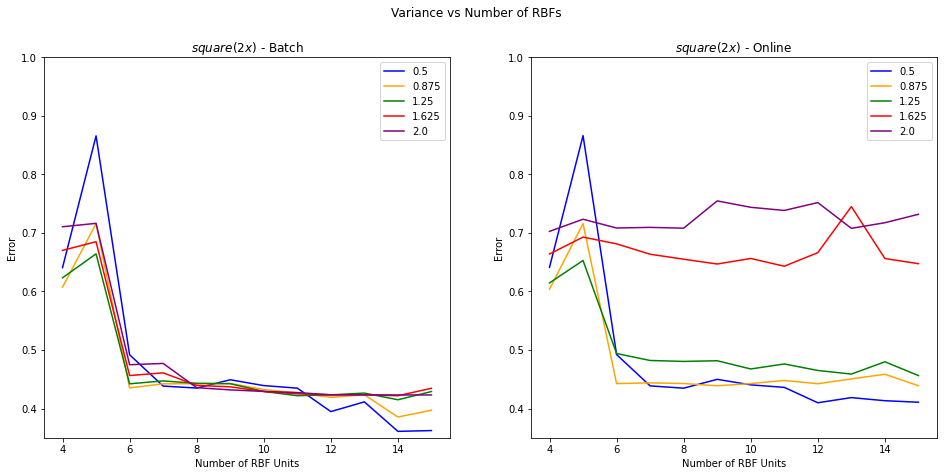

In [ ]:
color = ["blue", "orange", "green", "red", "purple"]

plt.figure(figsize=(16,7))
plt.suptitle("Variance vs Number of RBFs")

plt.subplot(121)
for i in range(0,len(variances)):
    plt.plot(np.arange(4,16,1), batch_err_square[i, :], c = color[i], label = variances[i])
plt.xlabel("Number of RBF Units")
plt.ylabel("Error")
plt.ylim([0.35, 1])
plt.title("$square(2x)$ - Batch")
plt.legend()

plt.subplot(122)
for i in range(0, len(variances)):
    plt.plot(np.arange(4,16,1), online_err_square[i, :], c = color[i], label = variances[i])
plt.xlabel("Number of RBF Units")
plt.ylabel("Error")
plt.ylim([0.35, 1])
plt.title("$square(2x)$ - Online")
plt.legend()

for batch: lower with sigma = 0.5 for 14 RBFs (0.361)

for online: lower with sigma = 0.5 for 12 RBFs (0.410)

the batch is faster (0.7seconds against 135 seconds) and more robust.

### Convergence rate

In [ ]:
print(online_err_sin[1,:], "\n", online_err_square[1,:])

[0.40947985 0.47053334 0.23650692 0.20903495 0.20567748 0.20797142
 0.20833603 0.21287403 0.21233009 0.21771653 0.21412285 0.21158319] 
 [0.60357442 0.71593595 0.44260206 0.44385609 0.44269771 0.4388391
 0.44255469 0.44802347 0.44229938 0.45062507 0.45850907 0.43894685]


In [ ]:
etas = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
n_unites = np.arange(4,16,1)
time_run_sin = []
eta_err_sin = np.zeros((len(etas), len(n_unites)))

np.random.seed(15)

for i, e in enumerate(etas):
    start_time = time.time()

    for j, n in enumerate(n_unites):
        v, w, sig = online_train(x, y_sin_n, n, "equal", 0.875, eta = e)
        pred_sin = predict(x_test, y_sin_test_n, v, w, n, sig)
        eta_err_sin[i,j] = absolute_residual_error(pred_sin, y_sin_test_n)

    time_run_sin.append(time.time() - start_time)

In [ ]:
time_run_square = []
eta_err_square = np.zeros((len(etas), len(n_unites)))

np.random.seed(15)

for i, e in enumerate(etas):
    start_time = time.time()

    for j, n in enumerate(n_unites):
        v, w, sig = online_train(x, y_square_n, n, "equal", 0.5, eta = e)
        pred_square = predict(x_test, y_square_test_n, v, w, n, sig)
        eta_err_square[i,j] = absolute_residual_error(pred_square, y_square_test_n)

    time_run_square.append((time.time() - start_time))

In [ ]:
print(time_run_sin, time_run_square)

[41.98550629615784, 20.564268112182617, 22.513620138168335, 20.468426942825317, 22.64061713218689, 20.818686723709106] [22.507582187652588, 20.415407180786133, 22.40267515182495, 20.985477685928345, 22.410198211669922, 22.518115997314453]


In [ ]:
eta_err_sin

array([[0.44413681, 0.49131662, 0.39520279, 0.37587955, 0.34791955,
        0.3485441 , 0.33111836, 0.32853046, 0.32810814, 0.31757431,
        0.30622481, 0.29906376],
       [0.41873303, 0.47472631, 0.31655017, 0.31786516, 0.313745  ,
        0.29936134, 0.30268487, 0.29611212, 0.28701249, 0.28893223,
        0.28531875, 0.2836237 ],
       [0.40963851, 0.46794569, 0.24004435, 0.23211691, 0.23276842,
        0.22859922, 0.22648366, 0.22478627, 0.22405066, 0.22175859,
        0.22355728, 0.2220304 ],
       [0.40973203, 0.46802048, 0.23229175, 0.21690783, 0.21809757,
        0.21718151, 0.21806307, 0.21780127, 0.21933967, 0.21865974,
        0.21759592, 0.21723328],
       [0.40954536, 0.46802038, 0.23695109, 0.2140868 , 0.22214585,
        0.20562122, 0.21832827, 0.22070114, 0.2118246 , 0.21600983,
        0.22278616, 0.21475246],
       [0.40997906, 0.46834957, 0.25528249, 0.20565801, 0.20927249,
        0.21393779, 0.20664802, 0.23640231, 0.21427501, 0.22314908,
        0.2089706 ,

#### Comparing plots

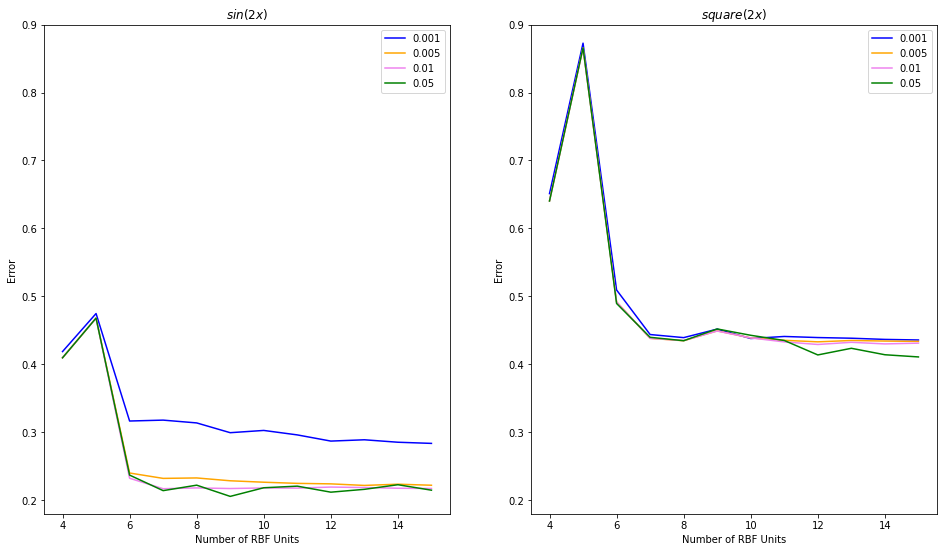

In [ ]:
color = ["purple", "blue", "orange", "violet", "green", "red", "grey" , "limegreen"]

plt.figure(figsize=(16,9))

plt.subplot(121)
for i in range(1,len(etas)-1):
    plt.plot(np.arange(4,16,1), eta_err_sin[i, :], c = color[i], label = etas[i])
plt.xlabel("Number of RBF Units")
plt.ylabel("Error")
plt.ylim([0.18, 0.9])
plt.title("$sin(2x)$")
plt.legend()

plt.subplot(122)
for i in range(1, len(etas)-1):
    plt.plot(np.arange(4,16,1), eta_err_square[i, :], c = color[i], label = etas[i])
plt.xlabel("Number of RBF Units")
plt.ylabel("Error")
plt.ylim([0.18, 0.9])
plt.title("$square(2x)$")
plt.legend()

### Initializations

#### Sin(2x)
Batch and Random

In [ ]:
start_time = time.time()

n_unites = np.arange(4,16,1)
batch_rand_sin = np.zeros((50, len(n_unites)))

np.random.seed(10)

for l in range(0,50):
    for j, n in enumerate(n_unites):

        v, w, sig = batch_train(x, y_sin_n, n, sigma_tr = 1.25)
        pred_sin_n = predict(x_test, y_sin_test_n, v, w, n, sig)
        batch_rand_sin[l,j] = absolute_residual_error(pred_sin_n, y_sin_test_n)

mu_sin_b = []
std_sin_b = []

for i in range(len(n_unites)):
    mu_sin_b.append(np.mean(batch_rand_sin[:,i]))
    std_sin_b.append(np.std(batch_rand_sin[:,i]))

print("--- %s seconds ---" % (time.time() - start_time))

--- 9.919613361358643 seconds ---


Online and Random

In [ ]:
start_time = time.time()

n_unites = np.arange(4,16,1)
on_rand_sin = np.zeros((10, len(n_unites)))

np.random.seed(15)

for l in range(0,10):
    for j, n in enumerate(n_unites):

        v, w, sig = online_train(x, y_sin_n, n, sigma_tr = 0.875, eta = 0.05)
        pred_sin_n = predict(x_test, y_sin_test_n, v, w, n, sig)
        on_rand_sin[l,j] = absolute_residual_error(pred_sin_n, y_sin_test_n)

mu_sin_o = []
std_sin_o = []

for i in range(len(n_unites)):
    mu_sin_o.append(np.mean(on_rand_sin[:,i]))
    std_sin_o.append(np.std(on_rand_sin[:,i]))

print("--- %s seconds ---" % (time.time() - start_time))

--- 239.5590043067932 seconds ---


Batch and equal

In [ ]:
n_unites = np.arange(4,16,1)
batch_eq_sin = np.zeros(len(n_unites))

start_time = time.time()

for j, n in enumerate(n_unites):
    v, w, sig = batch_train(x, y_sin_n, n, "equal", 1.25)
    pred_sin_n = predict(x_test, y_sin_test_n, v, w, n, sig)
    batch_eq_sin[j] = absolute_residual_error(pred_sin_n, y_sin_test_n)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.14893555641174316 seconds ---


Online and equal

In [ ]:
start_time = time.time()

n_unites = np.arange(4,16,1)
on_eq_sin = np.zeros(len(n_unites))

np.random.seed(15)
for j, n in enumerate(n_unites):

    v, w, sig = online_train(x, y_sin_n, n, "equal", 0.875, eta = 0.05)
    pred_sin_n = predict(x_test, y_sin_test_n, v, w, n, sig)
    on_eq_sin[j] = absolute_residual_error(pred_sin_n, y_sin_test_n)

print("--- %s seconds ---" % (time.time() - start_time))

--- 24.245402336120605 seconds ---


Comparison Plots

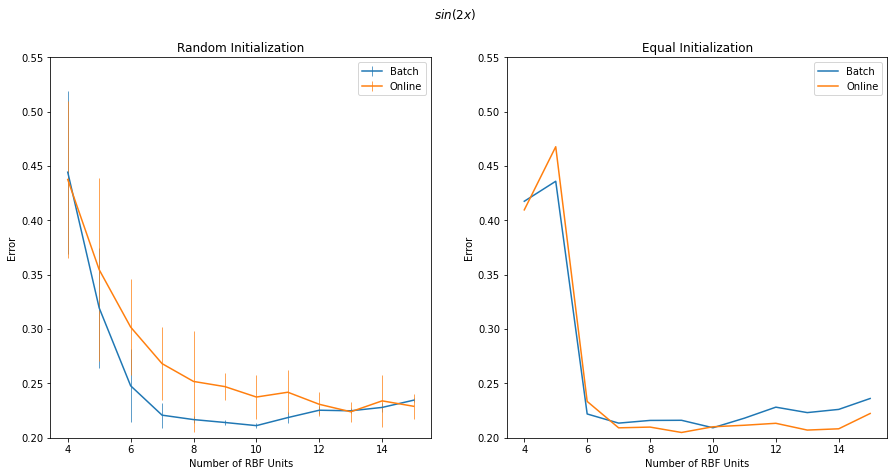

In [ ]:
# Plot errors sin(2x)

plt.figure(figsize=(15,7))
plt.suptitle("$sin(2x)$")

plt.subplot(121)
plt.errorbar(np.arange(4,16,1), mu_sin_b, yerr=std_sin_b, elinewidth = 0.7, label = "Batch")
plt.errorbar(np.arange(4,16,1), mu_sin_o, yerr=std_sin_o, elinewidth = 0.7, label = "Online")
# plt.axhline(y = 0.1, color = "red", linewidth = 0.8, ls = "--", label="0.1")
# plt.axhline(y = 0.01,color = "green", linewidth = 0.8, ls = "--", label="0.01")
# plt.axhline(y = 0.001, color = "purple", linewidth = 0.8, ls = "--", label="0.001")
plt.xlabel("Number of RBF Units")
plt.ylabel("Error")
plt.ylim([0.20, 0.55])
plt.title("Random Initialization")
plt.legend()

plt.subplot(122)
plt.plot(np.arange(4,16,1), batch_eq_sin, label = "Batch")
plt.plot(np.arange(4,16,1), on_eq_sin, label = "Online")
# plt.axhline(y = 0.1, color = "red", linewidth = 0.8, ls = "--", label="0.1")
# plt.axhline(y = 0.01,color = "green", linewidth = 0.8, ls = "--", label="0.01")
# plt.axhline(y = 0.001, color = "purple", linewidth = 0.8, ls = "--", label="0.001")
plt.xlabel("Number of RBF Units")
plt.ylabel("Error")
plt.ylim([0.20, 0.55])
plt.title("Equal Initialization")
plt.legend()

#### Square(2x)

Batch and Random

In [ ]:
start_time = time.time()

n_unites = np.arange(4,16,1)
batch_rand_square = np.zeros((50, len(n_unites)))

np.random.seed(10)

for l in range(0,50):
    for j, n in enumerate(n_unites):

        v, w, sig = batch_train(x, y_square_n, n, sigma_tr = 0.875)
        pred_square_n = predict(x_test, y_square_test_n, v, w, n, sig)
        batch_rand_square[l,j] = absolute_residual_error(pred_square_n, y_square_test_n)

mu_square_b = []
std_square_b = []

for i in range(len(n_unites)):
    mu_square_b.append(np.mean(batch_rand_square[:,i]))
    std_square_b.append(np.std(batch_rand_square[:,i]))

print("--- %s seconds ---" % (time.time() - start_time))

--- 7.259718179702759 seconds ---


Online and Random

In [ ]:
start_time = time.time()

n_unites = np.arange(4,16,1)
on_rand_square = np.zeros((10, len(n_unites)))

np.random.seed(10)

for l in range(0,10):
    for j, n in enumerate(n_unites):

        v, w, sig = online_train(x, y_square_n, n, sigma_tr = 0.875, eta = 0.05)
        pred_square_n = predict(x_test, y_square_test_n, v, w, n, sig)
        on_rand_square[l,j] = absolute_residual_error(pred_square_n, y_square_test_n)

mu_square_o = []
std_square_o = []

for i in range(len(n_unites)):
    mu_square_o.append(np.mean(on_rand_square[:,i]))
    std_square_o.append(np.std(on_rand_square[:,i]))

print("--- %s seconds ---" % (time.time() - start_time))

--- 306.43922114372253 seconds ---


Batch and Equal

In [ ]:
n_unites = np.arange(4,16,1)
batch_eq_square = np.zeros(len(n_unites))

start_time = time.time()

for j, n in enumerate(n_unites):
    v, w, sig = batch_train(x, y_square_n, n, "equal", 0.875)
    pred_square_n = predict(x_test, y_square_test_n, v, w, n, sig)
    batch_eq_square[j] = absolute_residual_error(pred_square_n, y_square_test_n)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.2548234462738037 seconds ---


Online and equal

In [ ]:
start_time = time.time()

n_unites = np.arange(4,16,1)
on_eq_square = np.zeros(len(n_unites))

np.random.seed(10)
for j, n in enumerate(n_unites):

    v, w, sig = online_train(x, y_square_n, n, "equal", 0.875, eta = 0.05)
    pred_square_n = predict(x_test, y_square_test_n, v, w, n, sig)
    on_eq_square[j] = absolute_residual_error(pred_square_n, y_square_test_n)

print("--- %s seconds ---" % (time.time() - start_time))

--- 22.504974126815796 seconds ---


Plots

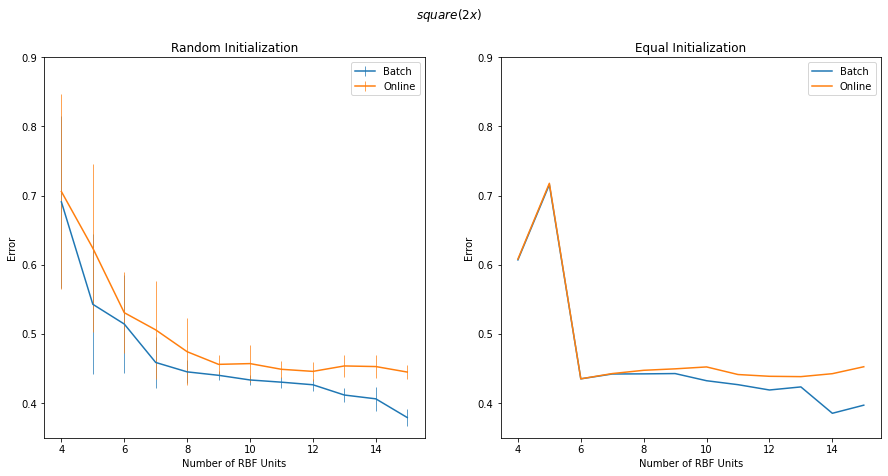

In [ ]:
# Plot errors square(2x)

plt.figure(figsize=(15,7))
plt.suptitle("$square(2x)$")

plt.subplot(121)
plt.errorbar(np.arange(4,16,1), mu_square_b, yerr=std_square_b, elinewidth = 0.7, label = "Batch")
plt.errorbar(np.arange(4,16,1), mu_square_o, yerr=std_square_o, elinewidth = 0.7, label = "Online")
# plt.axhline(y = 0.1, color = "red", linewidth = 0.8, ls = "--", label="0.1")
# plt.axhline(y = 0.01,color = "green", linewidth = 0.8, ls = "--", label="0.01")
# plt.axhline(y = 0.001, color = "purple", linewidth = 0.8, ls = "--", label="0.001")
plt.xlabel("Number of RBF Units")
plt.ylabel("Error")
plt.ylim([0.35, 0.90])
plt.title("Random Initialization")
plt.legend()

plt.subplot(122)
plt.plot(np.arange(4,16,1), batch_eq_square, label = "Batch")
plt.plot(np.arange(4,16,1), on_eq_square, label = "Online")
# plt.axhline(y = 0.1, color = "red", linewidth = 0.8, ls = "--", label="0.1")
# plt.axhline(y = 0.01,color = "green", linewidth = 0.8, ls = "--", label="0.01")
# plt.axhline(y = 0.001, color = "purple", linewidth = 0.8, ls = "--", label="0.001")
plt.xlabel("Number of RBF Units")
plt.ylabel("Error")
plt.ylim([0.35, 0.90])
plt.title("Equal Initialization")
plt.legend()

### Comparison clean and noisy

Error Sin(2x) Clean:  0.0008265653225731158
Error Sin(2x) Noisy:  0.20923250282053527
Error Square(2x) Clean:  0.0
Error Square(2x) Noisy:  0.36098637150292756
--- 0.09747457504272461 seconds ---


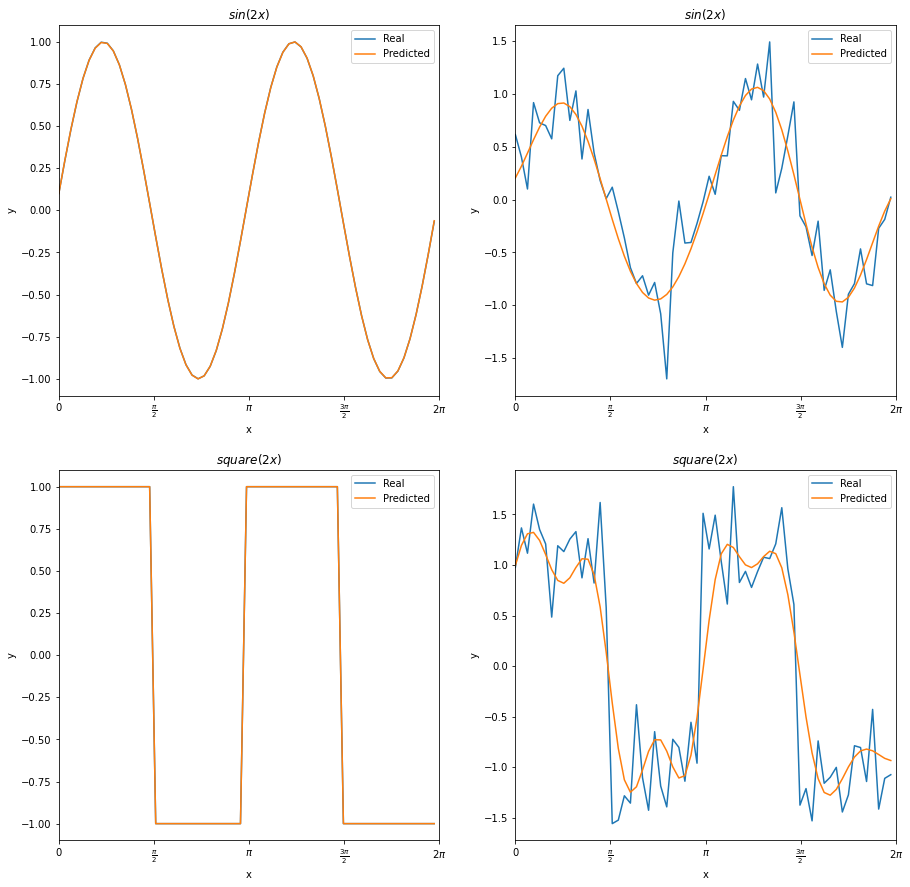

In [ ]:
start_time = time.time()

# clean sin
v_sin, w_sin, sig_sin = batch_train(x, y_sin, 10, "equal", 1.25)
pred_sin = predict(x_test, y_sin_test, v_sin, w_sin, 10, sig_sin)
err_sin = absolute_residual_error(pred_sin, y_sin_test)

print("Error Sin(2x) Clean: ", err_sin)

# noisy sin
v_sin, w_sin, sig_sin = batch_train(x, y_sin_n, 10, "equal", 1.25)
pred_sin_n = predict(x_test, y_sin_test_n, v_sin, w_sin, 10, sig_sin)
err_sin_n = absolute_residual_error(pred_sin_n, y_sin_test_n)

print("Error Sin(2x) Noisy: ", err_sin_n)

# clean square
v_sin, w_sin, sig_sin = batch_train(x, y_square, 14, "equal", 0.5)
pred_square = predict(x_test, y_square_test, v_sin, w_sin, 14, sig_sin)
pred_square_t = np.array([-1.0 if i < 0 else 1.0 for i in pred_square]).reshape(63,1)
err_square = absolute_residual_error(pred_square_t, y_square_test)

print("Error Square(2x) Clean: ", err_square)

# noisy square
v_sin, w_sin, sig_sin = batch_train(x, y_square_n, 14, "equal", 0.5)
pred_square_n = predict(x_test, y_square_test_n, v_sin, w_sin, 14, sig_sin)
#pred_square_tn = np.array([-1.0 if i < 0 else 1.0 for i in pred_square_n]).reshape(63,1)
err_square_n = absolute_residual_error(pred_square_n, y_square_test_n)

print("Error Square(2x) Noisy: ", err_square_n)

print("--- %s seconds ---" % (time.time() - start_time))


plt.figure(figsize=(15,15))
#plt.suptitle("$square(2x)$")

plt.subplot(221)
plt.plot(x, y_sin_test, label="Real")
plt.plot(x, pred_sin, label="Predicted")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
#plt.ylim([-1.3,1.3])
plt.title("$sin(2x)$")
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
plt.legend(loc = "upper right")

plt.subplot(222)
plt.plot(x, y_sin_test_n, label="Real")
plt.plot(x, pred_sin_n, label="Predicted")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
#plt.ylim([-1.3,1.3])
plt.title("$sin(2x)$")
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
plt.legend(loc = "upper right")

plt.subplot(223)
plt.plot(x, y_square_test, label="Real")
plt.plot(x, pred_square_t, label="Predicted")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
#plt.ylim([-1.3,1.3])
plt.title("$square(2x)$")
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
plt.legend(loc = "upper right")

plt.subplot(224)
plt.plot(x, y_square_test_n, label="Real")
plt.plot(x, pred_square_n, label="Predicted")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
#plt.ylim([-1.3,1.3])
plt.title("$square(2x)$")
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
plt.legend(loc = "upper right")

### Comparison MLP and RBF

Error MLP sin:  0.3032590770426714
--- 0.19383788108825684 seconds ---
Error RBF sin:  0.20923250282053527
--- 0.02198934555053711 seconds ---
Error MLP square:  0.43563435666372846
--- 0.13919329643249512 seconds ---
Error RBF square:  0.36098637150292756
--- 0.031048297882080078 seconds ---


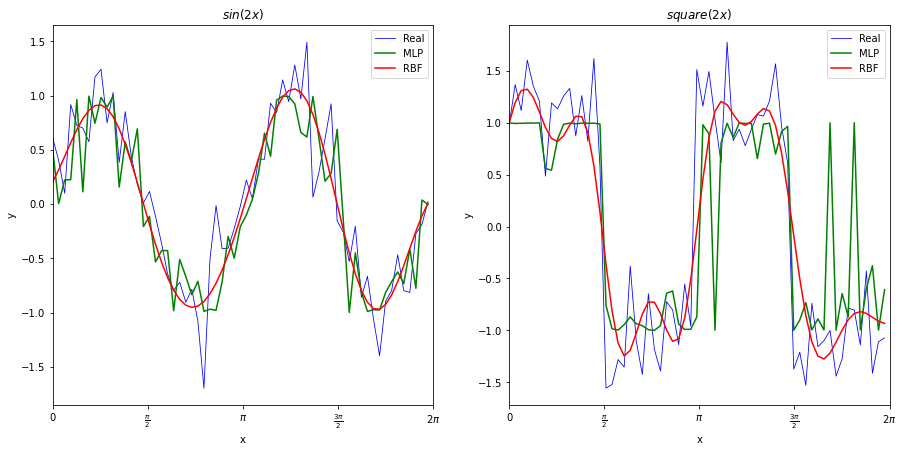

In [ ]:
#mlp sin
start_time = time.time()

np.random.seed(7)
nn = NeuralNetwork(x, y_sin_n, n_hidden_neurons=7, eta=0.1, alpha = 0)
nn.train(500)

pred_sin_mlp = nn.predict(x_test)
err_sin_mlp = absolute_residual_error(pred_sin_mlp, y_sin_test_n)
print("Error MLP sin: ", err_sin_mlp)

print("--- %s seconds ---" % (time.time() - start_time))

# rbf sin
start_time = time.time()

v, w, sig = batch_train(x, y_sin_n, 10, "equal", 1.25)
pred_sin_rbf = predict(x_test, y_sin_test_n, v, w, 10, sig)
err_sin_rbf = absolute_residual_error(pred_sin_rbf, y_sin_test_n)

print("Error RBF sin: ", err_sin_rbf)

print("--- %s seconds ---" % (time.time() - start_time))

#mlp square
start_time = time.time()

np.random.seed(7)
nn = NeuralNetwork(x, y_square_n, n_hidden_neurons=14, eta=0.1, alpha = 0)
nn.train(500)

pred_square_mlp = nn.predict(x_test)
err_square_mlp = absolute_residual_error(pred_square_mlp, y_square_test_n)
print("Error MLP square: ", err_square_mlp)

print("--- %s seconds ---" % (time.time() - start_time))


#rbf square
start_time = time.time()

v, w, sig = batch_train(x, y_square_n, 14, "equal", 0.5)
pred_square_rbf = predict(x_test, y_square_test_n, v, w, 14, sig)
err_square_rbf = absolute_residual_error(pred_square_rbf, y_square_test_n)

print("Error RBF square: ", err_square_rbf)

print("--- %s seconds ---" % (time.time() - start_time))


plt.figure(figsize=(15,7))

plt.subplot(121)
plt.plot(x, y_sin_test_n, label="Real", c = "blue", lw = 0.8)
plt.plot(x, pred_sin_mlp, label="MLP", c = "green")
plt.plot(x, pred_sin_rbf, label="RBF", c = "red")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
#plt.ylim([-1.3,1.3])
plt.title("$sin(2x)$")
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
plt.legend(loc = "upper right")

plt.subplot(122)
plt.plot(x, y_square_test_n, label="Real", c = "blue", lw = 0.8)
plt.plot(x, pred_square_mlp, label="MLP", c = "green")
plt.plot(x, pred_square_rbf, label="RBF", c = "red")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
#plt.ylim([-1.3,1.3])
plt.title("$square(2x)$")
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
plt.legend(loc = "upper right")

##3.3

### Comparing CL with even distribution on sin(2x)

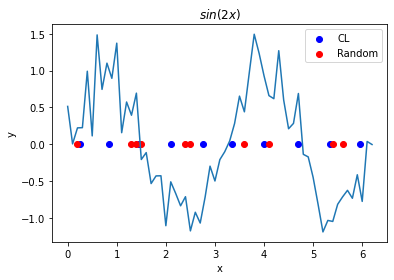

In [ ]:
# training and test data
"""
x = np.arange(0, 2*np.pi, 0.1)[:, np.newaxis]
x_test = np.arange(0.05, 2*np.pi, 0.1)[:, np.newaxis]

y_sin, y_square = functions(x, noise_variance=None)
y_sin_test, y_square_test = functions(x_test, noise_variance=None)
"""

def visualizeRBFs(v, ax=None, color="r", lab = ""):
    #If weights are one dimension plots them at y=0
    if v.shape[0]==1:
        v=np.concatenate((v, np.zeros((1,v.shape[1]))), axis=0)
    if ax:
        ax.scatter(v[0],v[1],c=color, label = lab)
    else:
        plt.scatter(v[0],v[1],c=color, label = lab)

#Clean best
np.random.seed(2)

v_clean, w_clean, sig = batch_train(x, y_sin, 6, "random")
pred_sin_clean = predict(x_test, y_sin_test, v_clean, w_clean, 6, sig)

#Noisy best
v_noisy, w_noisy, sig = batch_train(x, y_sin_n, 10, "random", 0.875)
pred_sin_noisy = predict(x_test, y_sin_test, v_noisy, w_noisy, 10, sig)

#Clean CL (one learning node)
v_clean_CL, w_clean_CL, sig = batch_train(x, y_sin, 6, "random", CL=1)
pred_sin_clean_CL = predict(x_test, y_sin_test, v_clean_CL, w_clean_CL, 6, sig)

#Noisy CL (one learning node)
v_noisy_CL, w_noisy_CL, sig = batch_train(x, y_sin_n, 10, "random", 0.875, CL=1)
pred_sin_eq_noisy_CL = predict(x_test, y_sin_test, v_noisy_CL, w_noisy_CL, 10, sig)

ax=plt.subplot()
visualizeRBFs(v_noisy_CL, ax, color="b", lab = "CL")
visualizeRBFs(v_noisy, ax, lab = "Random")
ax.plot(x, y_sin_n)
plt.xlabel("x")
plt.ylabel("y")
plt.title("$sin(2x)$")
plt.legend()

#Here there are no logical clusters since the data is evenly distributed along the axis, what happens is that CL makes the rbfs spread out similarly too an equal distribution
#Test and make sure that this is what happens

Shows an example of how the clusters can be positioned

In [ ]:
#Calculating mean and std over 30 itterations on sin(2x) (random and equal starting points)
N=50

results_clean_random=np.zeros(N)
results_clean_CL_random=np.zeros(N)
results_noisy_random=np.zeros(N)
results_noisy_CL_random=np.zeros(N)
results_clean_equal=np.zeros(N)
results_clean_CL_equal=np.zeros(N)
results_noisy_equal=np.zeros(N)
results_noisy_CL_equal=np.zeros(N)

for i in range(N):
    #clean best
    v_clean, w_clean, sig = batch_train(x, y_sin, 6, "random")
    results_clean_random[i] = absolute_residual_error(predict(x_test, y_sin_test, v_clean, w_clean, 6, sig), y_sin_test)
    v_clean, w_clean, sig = batch_train(x, y_sin, 6, "equal")
    results_clean_equal[i] = absolute_residual_error(predict(x_test, y_sin_test, v_clean, w_clean, 6, sig), y_sin_test)

    #Noisy best
    v_noisy, w_noisy, sig = batch_train(x, y_sin_n, 10, "random", 0.875)
    results_noisy_random[i] = absolute_residual_error(predict(x_test, y_sin_test, v_noisy, w_noisy, 10, sig), y_sin_test)
    v_noisy, w_noisy, sig = batch_train(x, y_sin_n, 10, "equal", 0.875)
    results_noisy_equal[i] = absolute_residual_error(predict(x_test, y_sin_test, v_noisy, w_noisy, 10, sig), y_sin_test)

    #Clean CL (one learning node)
    v_clean_CL, w_clean_CL, sig = batch_train(x, y_sin, 6, "random", CL=1)
    results_clean_CL_random[i] = absolute_residual_error(predict(x_test, y_sin_test, v_clean_CL, w_clean_CL, 6, sig), y_sin_test)
    v_clean_CL, w_clean_CL, sig = batch_train(x, y_sin, 6, "equal", CL=1)
    results_clean_CL_equal[i] = absolute_residual_error(predict(x_test, y_sin_test, v_clean_CL, w_clean_CL, 6, sig), y_sin_test)

    #Noisy CL (one learning node)
    v_noisy_CL, w_noisy_CL, sig = batch_train(x, y_sin_n, 10, "random", 0.875, CL=1)
    results_noisy_CL_random[i] = absolute_residual_error(predict(x_test, y_sin_test, v_noisy_CL, w_noisy_CL, 10, sig), y_sin_test)
    v_noisy_CL, w_noisy_CL, sig = batch_train(x, y_sin_n, 10, "equal", 0.875, CL=1)
    results_noisy_CL_equal[i] = absolute_residual_error(predict(x_test, y_sin_test, v_noisy_CL, w_noisy_CL, 10, sig), y_sin_test)

def printHelp(titel, results):
    print(titel+':\t\tMean:', np.mean(results),"\t\tStd:",np.std(results))

printHelp("Clean random   ", results_clean_random)
printHelp("Clean random CL", results_clean_CL_random)
printHelp("Clean equal    ", results_clean_equal)
printHelp("Clean equal  CL", results_clean_CL_equal)
printHelp("Noisy random   ", results_noisy_random)
printHelp("Noisy random CL", results_noisy_CL_random)
printHelp("Noisy equal    ", results_noisy_equal)
printHelp("Noisy equal  CL", results_noisy_CL_equal)

Clean random   :		Mean: 0.11202013033032926 		Std: 0.0632672942805245
Clean random CL:		Mean: 0.04717663976462474 		Std: 0.03870652862611871
Clean equal    :		Mean: 0.04601713523180217 		Std: 6.938893903907228e-18
Clean equal  CL:		Mean: 0.03820470544374195 		Std: 0.0019095702437986447
Noisy random   :		Mean: 0.08546524178384178 		Std: 0.008350911864087167
Noisy random CL:		Mean: 0.07795080983308521 		Std: 0.00014559221678243778
Noisy equal    :		Mean: 0.0774522133851861 		Std: 0.0
Noisy equal  CL:		Mean: 0.07802304198405356 		Std: 0.00023450673948794288


###Two dimensional from given data set

Text(0, 0.5, 'velocity')

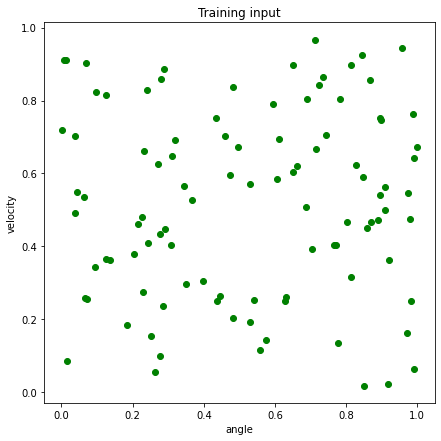

In [ ]:
#Load data sets
N_train=N_test=100
data_train=np.zeros((N_train,2))
target_train=np.zeros((N_train,2))
data_test=np.zeros((N_test,2))
target_test=np.zeros((N_test,2))

file=open(filepath+"ballist.dat")
for i in range(N_train):
    l = file.readline().strip().split()
    data_train[i,0]=float(l[0])
    data_train[i,1]=float(l[1])
    target_train[i,0]=float(l[2])
    target_train[i,1]=float(l[3])

file=open(filepath+"balltest.dat")
for i in range(N_test):
    l = file.readline().strip().split()
    data_test[i,0]=float(l[0])
    data_test[i,1]=float(l[1])
    target_test[i,0]=float(l[2])
    target_test[i,1]=float(l[3])

#Show training data
plt.figure(figsize=(7,7))
scatter = plt.scatter(data_train[:,0], data_train[:,1], c="g")
plt.title("Training input")
plt.xlabel("angle")
plt.ylabel("velocity")

Showing the effect of competitive learning and "multiple winners"

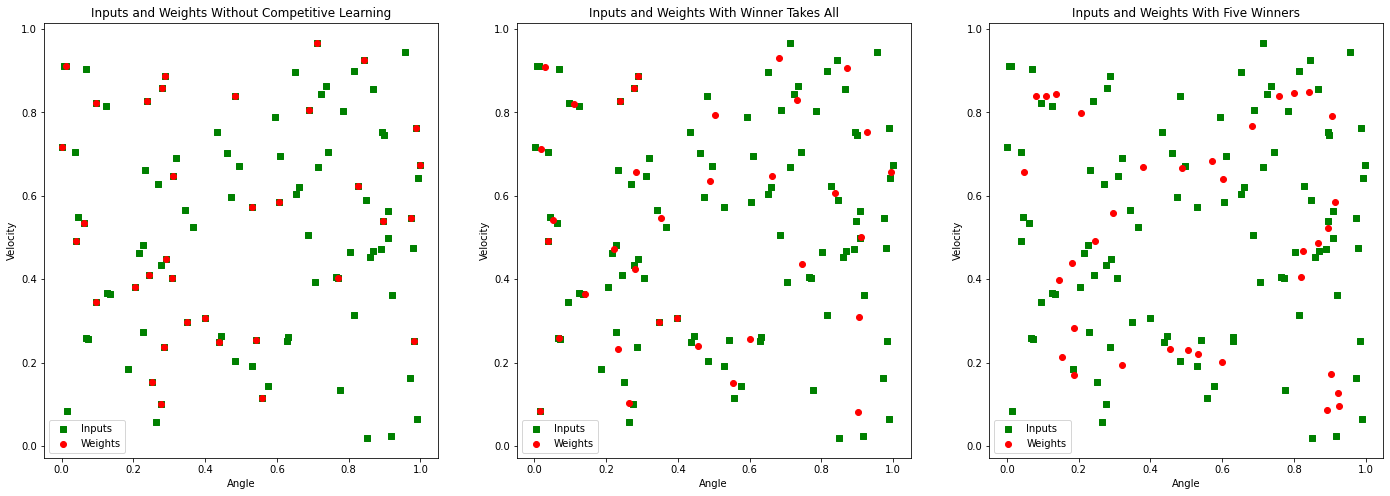

In [ ]:
#Training a network without CL
np.random.seed(2)

v, w, sig = batch_train(data_train, target_train, 35, "random")
pred_func = predict(data_test, target_test, v, w, 35, sig)

#Show training data
fig=plt.figure(figsize=(24,8))
ax=fig.add_subplot(1,3,1)
ax.scatter(data_train[:,0], data_train[:,1], c="g", label = "Inputs", marker = "s")
ax.set_title("Inputs and Weights Without Competitive Learning")
ax.set_xlabel("Angle")
ax.set_ylabel("Velocity")
visualizeRBFs(v, ax, lab = "Weights")
plt.legend(loc = "lower left")

#Training a network with winner takes all
np.random.seed(2)

v, w, sig = batch_train(data_train, target_train, 35, "random", CL=1)
pred_func = predict(data_test, target_test, v, w, 35, sig)

#Show training data
ax=fig.add_subplot(1,3,2)
ax.scatter(data_train[:,0], data_train[:,1], c="g", label = "Inputs", marker = "s")
ax.set_title("Inputs and Weights With Winner Takes All")
ax.set_xlabel("Angle")
ax.set_ylabel("Velocity")
visualizeRBFs(v, ax, lab = "Weights")
plt.legend(loc = "lower left")

#Training a network with multiple winners
np.random.seed(2)

v, w, sig = batch_train(data_train, target_train, 35, "random", CL=5)
pred_func = predict(data_test, target_test, v, w, 35, sig)

#Show training data
ax=fig.add_subplot(1,3,3)
ax.scatter(data_train[:,0], data_train[:,1], c="g", label = "Inputs", marker = "s")
ax.set_title("Inputs and Weights With Five Winners")
ax.set_xlabel("Angle")
ax.set_ylabel("Velocity")
visualizeRBFs(v, ax, lab = "Weights")
plt.legend(loc = "lower left")

To me it seems to capture the data worse when using multiple winners. It seems to disregard lone nodes and focus on the data points in the denser clusters near the center.

####Approximating 2D function using RBF

In [ ]:
#Evaluating network over 50 random itterations  (Don't run this one since it takes 5 min LOL)
N=50
results=np.zeros((N,6))

for i in range(N):
    for cl in range(6):
        v, w, sig = batch_train(data_train, target_train, 35, "random", CL=cl)
        pred_func = predict(data_test, target_test, v, w, 35, sig)
        results[i,cl]= absolute_residual_error(pred_func, target_test)

print(results.mean(axis=0))
print(results.std(axis=0))


[0.04119773 0.03043321 0.03642414 0.04535075 0.04953745 0.05856381]
[0.01272672 0.00750824 0.00555697 0.00603593 0.00528473 0.00621306]


Text(0.5, 1.0, 'Error over Winning Nodes')

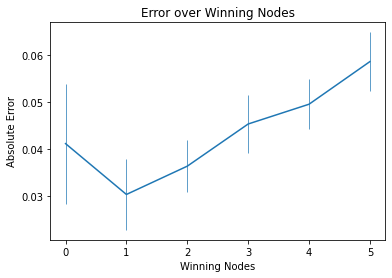

In [ ]:
#Printing the results
result_std=results.std(axis=0)
result_mean=results.mean(axis=0)

plt.figure()

plt.errorbar(np.arange(6), result_mean, yerr=result_std, elinewidth = 0.7)
# plt.axhline(y = 0.1, color = "red", linewidth = 0.8, ls = "--", label="0.1")
# plt.axhline(y = 0.01,color = "green", linewidth = 0.8, ls = "--", label="0.01")
# plt.axhline(y = 0.001, color = "purple", linewidth = 0.8, ls = "--", label="0.001")
plt.xlabel("Winning Nodes")
plt.ylabel("Absolute Error")
#plt.ylim([0.35, 0.90])
plt.title("Error over Winning Nodes")

When using CL with initialization on data points it allows the RBFs to spread out and capture a more representing area around the point where they were initialized.

#SOMs

In [ ]:
#data generation
data = np.fromfile(filepath+"/animals.dat",sep=',',dtype="int")
data=np.reshape(data,(32,84))

In [ ]:
#usefull functions
def squaredDistance(v1,v2):
    return np.dot(np.transpose(v1-v2),(v1-v2))

def findClosest(v,weight):
    mindis=np.inf
    index=-1
    for i in range(np.shape(weight)[0]):
        d=squaredDistance(v,weight[i])
        if d<mindis:
            mindis=d
            index=i
    return index

def indexDist(i,j):
    if i<j:
        return min(j-i,100-j+i)
    return min(i-j,100-i+j)

In [ ]:
def SOM(data,epoch,learning_rate):
    weight=np.random.uniform(0, 1, size=(100,84))
    for e in range(epoch):
        for i in range(np.shape(data)[0]):
            index=findClosest(data[i],weight)
            for j in range(100):
                if indexDist(index,j)<5:
                    weight[j]=weight[j]+learning_rate*(data[i]-weight[j])
    return weight

#Gustavs implementation of a SOM

In [ ]:
#Calculates the euclidian distance between two vectors (or between a input vector (N,) and each weight in weight matrix (M,N))
def euclidean(input, weights, compare=False):
    #vectors
    if weights.ndim==1:
        assert (len(input)==len(weights)), "Dimension error"
        if compare:     #If we don't care about the actual values but simply which is largest
            return np.dot(input-weights, input-weights)
        return np.sqrt(np.dot(input-weights, input-weights))

    #vector and matrix
    assert (len(input)==weights.shape[1]), "Dimension error"
    input=input.reshape((len(input),1))
    weights=weights.T
    if compare:        #If we don't care about the actual values but simply which is largest
        return np.sum( (input - weights) * (input - weights), axis=0 )
    return np.sqrt( np.sum( (input - weights) * (input - weights), axis=0 ) )

#The SOM network
class SOMnetwork:
    #Sets up the structure of the network
    def __init__(self, dimInput, dimOutput, neighbourhoodType="line", neighbourhoodDistance="manhattan", simFunc=euclidean):
        self.dimInput=dimInput      #Dimension of input layer
        self.dimOutput=dimOutput    #Dimension (aka how many nodes since it is discrete) of output layer
        self.weights = np.random.rand(dimOutput, dimInput)          ################From assignment 4.1. I suspect it could give some funcky results in general
        self.neighbourhoodType = neighbourhoodType      #What kind of neighbourhood the network has: line, circle or square
        self.neighbourhoodDistance = neighbourhoodDistance      #What metric to use for distance in neighbourhood: manhattan or Gaussian (applied on the euclidian distance)
        self.neighbourhood = self.createNeighbourhood()
        self.similarity=simFunc     #The function for calculating similarity in the input space

    #Run this before training to set up the parameters of the network (Decay here is how many epochs to reach zero with the exception that a decay of zero never changes the parameter)
    def setParameters(self, initialLr, initialNeighbourhoodSize, lrDecay=0, neighbourhoodSizeDecay=0):  #(0.2, 3, 0, 50)
        self.initialLr=initialLr
        self.lr=initialLr
        self.lrDecay=lrDecay
        self.initialNeighbourhoodSize=initialNeighbourhoodSize
        self.neighbourhoodSize=initialNeighbourhoodSize #How many get affected with manhattan distance, the std deviation for Gaussian
        self.neighbourhoodDecay=neighbourhoodSizeDecay

    #Creates the matrix representing the neighbourhood connections
    def createNeighbourhood(self):
        assert (self.neighbourhoodType=="line" or self.neighbourhoodType=="circle" or self.neighbourhoodType=="square"), "Neighbourhood type \"{self.neighbourhoodType}\" does not exist!"

        if self.neighbourhoodType=="square":
            side=math.isqrt(self.dimOutput)
            assert self.dimOutput==side**2, "The output dimension can not be a square!"
            return np.arange(self.dimOutput).reshape((side,side))

        #If circle or line
        return np.arange(self.dimOutput)

    #Caclulates how much each node in the neighbourhood should update using the distances
    def calculateNeighbourhoodUpdates(self, d):
        assert (self.neighbourhoodDistance=="manhattan" or self.neighbourhoodDistance=="Gaussian"), "Error! Neighbourhood distance must be \'manhattan\' or \'Gaussian\'"
        h=np.zeros_like(self.neighbourhood).astype(float)

        #If distance is manhattan
        if self.neighbourhoodDistance=="manhattan":
            nSize=math.floor(self.neighbourhoodSize)
            h_values=np.arange(nSize,0,-1)/nSize    #Values begining from 1 and stopping at 1/neighbourhoodSize
            #h_values=np.ones(nSize)        #Updates all nodes in manhattan distance equally

            if self.neighbourhoodType=="line" or self.neighbourhoodType=="circle":
                for i in range(self.dimOutput):
                    if d[i]<nSize:
                        h[i]=h_values[d[i]]

            if self.neighbourhoodType=="rectangle":
                side=math.isqrt(self.dimOutput)
                for x in range(side):
                    for y in range(side):
                        if d[x,y]<nSize:
                            h[x,y]=h_values[d[x,y]]

            return h

        #If distance is Gaussian
        return np.exp(-0.5*np.power(d/self.neighbourhoodSize,2))

    #Calculates the distances in the neighbourhood
    def calculateNeighbourhoodDistances(self, winningNode):
        h=np.zeros_like(self.neighbourhood)
        d=np.zeros_like(self.neighbourhood)
        nSize=math.floor(self.neighbourhoodSize)

        if self.neighbourhoodType=="line":
            d=np.absolute(np.arange(self.dimOutput)-winningNode)

        if self.neighbourhoodType=="circle":
            forward=np.arange(self.dimOutput)
            forward=np.roll(forward,winningNode)
            backward=np.arange(self.dimOutput-1,-1,-1)
            backward=np.roll(backward,winningNode+1)
            d=np.minimum(forward,backward)

        if self.neighbourhoodType=="square":
            side=math.isqrt(self.dimOutput)
            winningx=winningNode % side
            dx=np.absolute(np.arange(side)-winningx).reshape((1,side))    #Difference in x dimension
            dx=np.ones((side,side))*dx

            winningy=winningNode // side
            dy=np.absolute(np.arange(side)-winningy).reshape((1,side))    #Difference in y dimension
            dy=np.ones((side,side))*dy
            dy=dy.T

            if self.neighbourhoodDistance=="manhattan":
                d=dx+dy
            if self.neighbourhoodDistance=="Gaussian":
                d=np.sqrt(np.power(dx,2)+np.power(dy,2))

        return d

    #Updates the weights
    def updateWeights(self, pattern, h):
        hflat=h.reshape((self.dimOutput,1))
        xMinusW=pattern.reshape((self.dimInput,1))-self.weights.T       #Matrix (dimIn,dimOut) of pattern subtracted by weights
        self.weights=self.weights + self.lr * hflat * xMinusW.T


    #Reduces the hyper parameters values using a linear decay
    def decayParameters(self):
        if self.lrDecay!=0 and self.lr!=0:
            self.lr-=self.initialLr/self.lrDecay
            if self.lr<0:
                self.lr=0

        if self.neighbourhoodDecay!=0 and self.neighbourhoodSize!=0:
            self.neighbourhoodSize-=self.initialNeighbourhoodSize/self.neighbourhoodDecay
            if self.neighbourhoodSize<0:
                self.neighbourhoodSize=0

    #Train the network for 'epochs' epochs
    def train(self, data, epochs):
        n=data.shape[0]
        for e in range(epochs):
            for pattern in range(n):
                #Index of winning node
                winningNode=np.argmin(self.similarity(data[pattern],self.weights))
                #Calculates the neighbourhood updates
                d=self.calculateNeighbourhoodDistances(winningNode)
                h=self.calculateNeighbourhoodUpdates(d)

                #Gain some insight into how h is calculated
                #if e==epochs-1 or e==round(epochs/2):
                #    print(h)

                self.updateWeights(data[pattern], h)

            self.decayParameters()

    #Returns the output of data with corresponding lables in the shape of the neighbourhood
    #If 'indexOut' is true it instead returns a vector of same size as labels with the correponding index which matches best
    def getOutput(self, data, labels, indexOut=False):
        n=data.shape[0]
        if not indexOut:        #If multiple labels are mapped to the same node they will be overwritten
            output=np.zeros_like(self.neighbourhood).astype(str)
            for pattern in range(n):
                #Index of winning node
                winningNode=np.argmin(self.similarity(data[pattern],self.weights))

                if self.neighbourhoodType!="square":
                    output[winningNode]=labels[pattern]

                else:
                    side=math.isqrt(self.dimOutput)
                    output[winningNode//side, winningNode%side]=labels[pattern]

        if indexOut:
            output=np.zeros(len(labels))
            for pattern in range(n):
                #Index of winning node
                winningNode=np.argmin(self.similarity(data[pattern],self.weights))
                output[pattern]=winningNode

        return output


###4.1 Topological Ordering of Animal Species

> Bloc en retrait



In [ ]:
#Load data
N_animals = 32
N_attributes = 84

data=np.zeros((N_animals,N_attributes))  #With format (number of patterns, number of attributes)

file = open(filepath + "animals.dat", 'r')
fullList=file.readline().strip().split(',')

for i in range(N_animals):
    patternList = fullList[i*N_attributes:(i+1)*N_attributes]
    data[i]=np.array(patternList, dtype=float)

#Load corresponding labels
labels=np.zeros(N_animals).astype(str)

file = open(filepath + "/animalnames.txt", 'r')

for i in range(N_animals):
    labels[i]=file.readline().strip()


In [ ]:
np.random.seed(15)

#Create network
SOM=SOMnetwork(84, 100, neighbourhoodType="line", neighbourhoodDistance="manhattan")
SOM.setParameters(0.2, 6, 0, 20)

#Train network
SOM.train(data,20)

#Get output
indexvector=SOM.getOutput(data,labels,indexOut=True)

#Sort vectors
sortedind=indexvector.argsort()

print(indexvector[sortedind])   #Showing how manytargets are grouped in the same node
print(labels[sortedind])

[79. 80. 80. 82. 83. 83. 84. 86. 86. 87. 87. 89. 90. 90. 91. 92. 92. 92.
 93. 93. 94. 94. 94. 95. 95. 96. 96. 97. 98. 98. 99. 99.]
["'dragonfly'" "'grasshopper'" "'beetle'" "'butterfly'" "'moskito'"
 "'housefly'" "'spider'" "'pelican'" "'duck'" "'penguin'" "'ostrich'"
 "'frog'" "'seaturtle'" "'crocodile'" "'walrus'" "'bear'" "'dog'"
 "'hyena'" "'lion'" "'cat'" "'skunk'" "'ape'" "'rat'" "'kangaroo'"
 "'rabbit'" "'elephant'" "'bat'" "'horse'" "'giraffe'" "'camel'" "'pig'"
 "'antelop'"]


###4.2 Cyclic tour

In [ ]:
#Load data
N_cities = 10
N_coordinates = 2

data=np.zeros((N_cities,N_coordinates))  #With format (number of patterns, number of attributes)

file = open(filepath+"cities.dat", 'r')
my_list = []

for _ in range(4):
    next(file)  # discard the first 4 lines
for line in file:
    values = line.strip().replace(";", "").split(',')
    my_list.append((float(values[0]), float(values[1])))

#print(my_list)

for i in range(N_cities):
    patternList = my_list[i]
    data[i]=np.array(patternList, dtype=float)

In [ ]:
np.random.seed(4)

#Create network
SOM=SOMnetwork(2, 10, neighbourhoodType="circle", neighbourhoodDistance="manhattan")
SOM.setParameters(0.2, 3, 0, 50)

#Train network
SOM.train(data,50)

labels=np.array(["1","2","3","4","5","6","7","8","9","10"])
#Get output
indexvector=SOM.getOutput(data,labels,indexOut=True)

#Sort vectors
sortedind=indexvector.argsort()

print(indexvector[sortedind])
print(labels[sortedind])
print(data[sortedind])

[0. 1. 2. 3. 3. 5. 5. 6. 7. 9.]
['6' '7' '8' '9' '10' '2' '3' '1' '4' '5']
[[0.8732 0.6536]
 [0.6878 0.5219]
 [0.8488 0.3609]
 [0.6683 0.2536]
 [0.6195 0.2634]
 [0.2439 0.1463]
 [0.1707 0.2293]
 [0.4    0.4439]
 [0.2293 0.761 ]
 [0.5171 0.9414]]


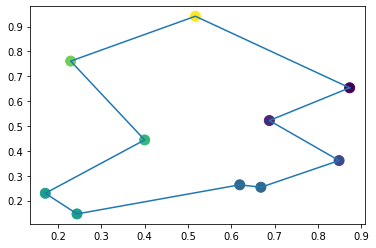

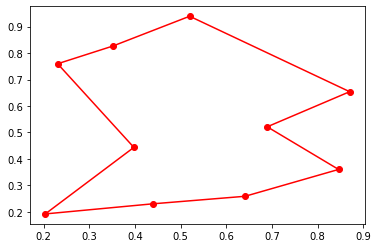

In [ ]:
#plotting

x=[]
y=[]
for p in data[sortedind]:
    x.append(p[0])
    y.append(p[1])
plt.scatter(x,y,c=indexvector[sortedind],s=100)
x.append(x[0])
y.append(y[0])
plt.plot(x,y)
plt.show()

#Plots the weights and neighbourhood in the input space
weightsx=SOM.weights[:,0]
weightsy=SOM.weights[:,1]
plt.scatter(weightsx, weightsy, c="r")
weightsx=np.append(weightsx,weightsx[0])
weightsy=np.append(weightsy,weightsy[0])
plt.plot(weightsx,weightsy,c="r")

###4.3 Data Clustering: Votes of MPs

In [ ]:
#Load data
N_MP = 349
N_Votes = 31

data=np.zeros((N_MP,N_Votes))  #With format (number of patterns, number of attributes)

file = open(filepath+"votes.dat", 'r')
fullList=file.readline().strip().split(',')

for i in range(N_MP):
    patternList = fullList[i*N_Votes:(i+1)*N_Votes]
    data[i]=np.array(patternList, dtype=float)

#Load corresponding labels
labels=np.zeros(N_MP).astype(int)

file = open(filepath+"mpparty.dat", 'r')
my_list = []

for _ in range(3):
    next(file)  # discard the first 4 lines

for i in range(N_MP):
    labels[i]=file.readline().strip()
print(labels)

[1 2 1 1 3 1 4 3 5 2 6 3 3 1 4 6 4 2 3 2 3 1 3 1 3 2 3 2 5 3 2 3 0 3 6 1 6
 1 1 2 3 3 3 3 3 3 1 6 1 3 3 1 2 5 4 3 1 2 2 4 7 2 1 1 5 2 2 3 1 4 7 3 1 3
 3 6 5 3 2 2 1 3 3 3 3 6 3 5 4 2 7 1 3 4 3 3 5 6 7 1 3 6 1 2 3 3 3 2 1 6 6
 3 3 4 3 7 3 6 3 1 2 1 7 3 3 3 6 2 7 6 3 1 4 3 3 3 2 3 3 3 3 1 6 2 3 3 3 3
 3 4 3 1 2 1 3 6 1 3 3 4 3 2 2 1 3 3 3 3 2 4 3 1 1 6 1 2 5 7 1 6 3 4 3 2 3
 7 1 3 3 3 3 3 3 2 4 6 2 1 7 1 3 2 4 3 2 3 1 1 4 6 1 5 6 3 3 3 2 2 3 4 1 1
 3 6 7 3 2 5 2 3 3 3 5 3 1 6 3 4 2 3 7 3 3 3 2 6 1 7 3 7 6 4 3 3 3 2 1 3 3
 4 3 7 2 6 1 5 3 3 3 3 3 1 4 5 2 7 3 6 3 3 3 2 1 3 3 3 7 4 6 3 3 1 2 7 5 3
 3 4 6 3 3 1 3 4 7 3 3 6 5 3 2 3 3 3 3 3 7 4 6 2 1 3 3 3 1 4 7 3 3 3 4 2 3
 6 1 5 3 7 3 3 3 4 5 6 3 3 3 1 2]


In [ ]:
np.random.seed(1)

#Create network
SOM=SOMnetwork(31, 100, neighbourhoodType="square", neighbourhoodDistance="manhattan")
SOM.setParameters(0.2, 2, 0, 20)

#Train network
SOM.train(data,20)

#Get output
indexvector=SOM.getOutput(data,labels,indexOut=True)

#Sort vectors
sortedind=indexvector.argsort()

print(indexvector[sortedind])
print(labels[sortedind])

[ 3.  3.  3.  4. 14. 14. 14. 17. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
 30. 30. 30. 30. 30. 30. 30. 30. 33. 33. 39. 39. 39. 39. 39. 44. 44. 45.
 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45.
 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45.
 45. 45. 45. 45. 49. 49. 49. 49. 49. 49. 54. 54. 54. 54. 54. 54. 54. 54.
 54. 54. 54. 54. 54. 56. 57. 57. 57. 57. 57. 57. 66. 66. 66. 66. 66. 66.
 66. 66. 66. 66. 66. 66. 66. 66. 66. 66. 66. 66. 66. 66. 66. 66. 66. 66.
 66. 66. 66. 66. 66. 66. 66. 66. 66. 66. 66. 66. 66

In [ ]:
#Load data
N_MP = 349
N_Votes = 31

data=np.zeros((N_MP,N_Votes))  #With format (number of patterns, number of attributes)

file = open("votes.dat", 'r')
fullList=file.readline().strip().split(',')

for i in range(N_MP):
    patternList = fullList[i*N_Votes:(i+1)*N_Votes]
    data[i]=np.array(patternList, dtype=float)

#Load corresponding labels
labels=np.zeros(N_MP).astype(int)

file = open("mpparty.dat", 'r')

for i in range(N_MP):
    labels[i]=file.readline().strip()

#Create network
SOM=SOMnetwork(31, 100, neighbourhoodType="square", neighbourhoodDistance="manhattan")
SOM.setParameters(0.2, 2, 0, 20)

#Train network
SOM.train(data,20)

#Get output
indexvector=SOM.getOutput(data,labels,indexOut=True)
print(indexvector)

#Sort vectors
sortedind=indexvector.argsort()


x=[]
y=[]
for l in indexvector[sortedind]:
    x.append(l//10+ rd.uniform(-0.5,0.5))
    y.append(l%10+rd.uniform(-0.5,0.5))


In [ ]:

colors = ['white','blue','cyan','pink','red','green','black','yellow']
party = ['no','m', 'fp', 's', 'v', 'mp', 'kd', 'c']



fig, ax = plt.subplots()
patch1 = mpatches.Patch(color='blue', label='Moderate')
patch2 = mpatches.Patch(color='cyan', label='Liberals')
patch3 = mpatches.Patch(color='pink', label='Socialdemocratic')
patch4 = mpatches.Patch(color='red', label='Left')
patch5 = mpatches.Patch(color='green', label='Green')
patch6 = mpatches.Patch(color='black', label='Christian Democrats')
patch7 = mpatches.Patch(color='yellow', label='Center')
ax.legend(handles=[patch1,patch2,patch3,patch4,patch5,patch6,patch7],  bbox_to_anchor=(1, 1))


plt.scatter(x,y,c=labels[sortedind],s=25,cmap=matplotlib.colors.ListedColormap(colors))

plt.show()

In [ ]:
#Load corresponding labels
labels=np.zeros(N_MP).astype(int)

file = open("mpsex.dat", 'r')

for i in range(N_MP):
    labels[i]=file.readline().strip()

#Sort vectors
sortedind=indexvector.argsort()


colors = ['blue','red']


fig, ax = plt.subplots()
patch1 = mpatches.Patch(color='blue', label='men')
patch2 = mpatches.Patch(color='red', label='women')

ax.legend(handles=[patch1,patch2],  bbox_to_anchor=(1, 1))


plt.scatter(x,y,c=labels[sortedind],s=25,cmap=matplotlib.colors.ListedColormap(colors))

plt.show()

In [ ]:
#Load corresponding labels
labels=np.zeros(N_MP).astype(int)

file = open("mpdistrict.dat", 'r')

for i in range(N_MP):
    labels[i]=file.readline().strip()

nbr=np.zeros(29)

for k in range(349):
    nbr[labels[k]-1]=nbr[labels[k]-1]+1

print(nbr)

In [ ]:
#Sort vectors
sortedind=indexvector.argsort()

plt.scatter(x,y,c=labels[sortedind],s=25)

plt.show()